#Natural Language Processing with Disaster Tweets
Predict which Tweets are about real disasters and which ones are not

#Dataset Description

##What files do I need?
You'll need train.csv, test.csv and sample_submission.csv.

##What should I expect the data format to be?
Each sample in the train and test set has the following information:

The text of a tweet
A keyword from that tweet (although this may be blank!)
The location the tweet was sent from (may also be blank)
What am I predicting?
You are predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

###Files
train.csv - the training set
test.csv - the test set
sample_submission.csv - a sample submission file in the correct format
Columns
id - a unique identifier for each tweet
text - the text of the tweet
location - the location the tweet was sent from (may be blank)
keyword - a particular keyword from the tweet (may be blank)
target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

#Pre-Processing

### Why to do text preprocessing ?
All the machine learning models available today only work on numerical values and do not understand the text as is. So we have to represent the textual information using numerical values. The textual data generated from natural languaes is inherently unstructured and noisy. To represent the text data, we have to clean it to remove parts of the text which do not add any information, such as punctuations and stopwords, to make the data more consistent. Such consistent data can be represented efficiently for the use in machine learning models.

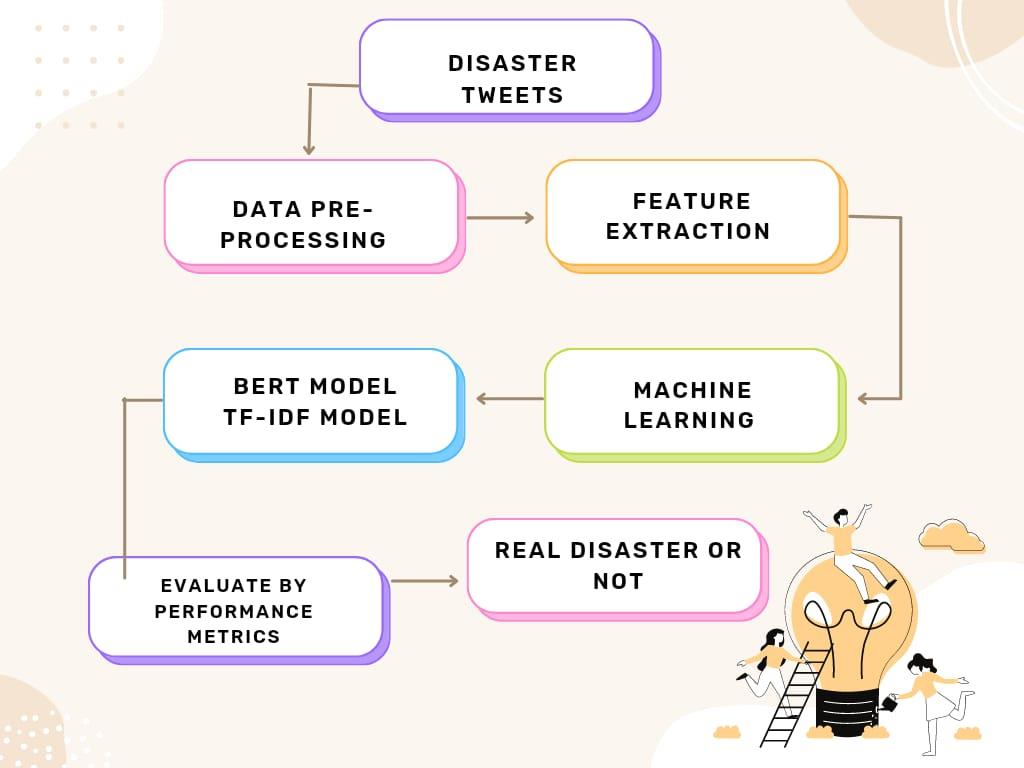

In [ ]:
import re
from nltk.corpus import stopwords
import string
import pandas as pd

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

In [ ]:
#loading Train CSV
tweets_df = pd.read_csv("/content/train.csv")
tweets_df.head()

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1

 If we check the description of the competition, we can observe that the keywords are important for the classification of distaster tweet and hence a combined tweet column is created by joining keyword and text. First the empty keywords are replaced by

In [ ]:
tweets_df["keyword"] = tweets_df["keyword"].fillna("")
tweets_df["tweet"] = tweets_df["keyword"] + " " + tweets_df["text"]
tweets_df.sample(5, random_state=42)

id      keyword               location  \
2644  3796  destruction                    NaN   
2227  3185       deluge                    NaN   
5448  7769       police                     UK   
132    191   aftershock                    NaN   
6845  9810       trauma  Montgomery County, MD   

                                                   text  target  \
2644  So you have a new weapon that can cause un-ima...       1   
2227  The f$&amp;@ing things I do for #GISHWHES Just...       0   
5448  DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...       1   
132   Aftershock back to school kick off was great. ...       0   
6845  in response to trauma Children of Addicts deve...       0   

                                                  tweet  
2644  destruction So you have a new weapon that can ...  
2227  deluge The f$&amp;@ing things I do for #GISHWH...  
5448  police DT @georgegalloway: RT @Galloway4Mayor:...  
132   aftershock Aftershock back to school kick off ...  
6845  trauma in response to trauma Children of Addic...

Lower Case
Lower casing is generally the first preprocessing step performed. As each word is considered as a token, if we consider all the possible combinations of the casings of the word, it will be  2^(len(word))
  possible different tokens for each word, like dataset, Dataset, DaTaSeT and so on. We want to represent the text as efficiently as possible and hence want to make the representation case insentitve, as generally the casing does not provide any addditional information. Exception to this are the abbreviations, which are handled separately.

In [ ]:
tweets_df["tweet_lower"] = tweets_df["tweet"].str.lower()
tweets_df["tweet_lower"].sample(5, random_state=42)

2644    destruction so you have a new weapon that can ...
2227    deluge the f$&amp;@ing things i do for #gishwh...
5448    police dt @georgegalloway: rt @galloway4mayor:...
132     aftershock aftershock back to school kick off ...
6845    trauma in response to trauma children of addic...
Name: tweet_lower, dtype: object

## Remove HTML
HTML stands for HyperText Markup Language, which is used for formatting the flow of the webpages. There are many html entities, which creep into the textual data such as "& gt;" and "& lt;". Also text might contain html tags such as < p >, < a > or < div >. It is important to remove these entities as they are nothing but noise and can negatively affect the performance of the model if not removed

In [ ]:
from bs4 import BeautifulSoup
text = r"&gt;&gt; $15 Aftershock : Protect Yourself and Profit in the Next Global Financial... ##book http://t.co/f6ntUc734Z esquireattire"
soup = BeautifulSoup(text)
soup.get_text()
def remove_html(text):
    soup = BeautifulSoup(text)
    text = soup.get_text()
    return text
tweets_df["tweet_noHTML"] = tweets_df["tweet_lower"].apply(remove_html)
tweets_df["tweet_noHTML"].sample(5, random_state=42)


<ipython-input-5-6bf1c0cb37d4>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text)
<ipython-input-5-6bf1c0cb37d4>:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text)


2644    destruction so you have a new weapon that can ...
2227    deluge the f$&@ing things i do for #gishwhes j...
5448    police dt @georgegalloway: rt @galloway4mayor:...
132     aftershock aftershock back to school kick off ...
6845    trauma in response to trauma children of addic...
Name: tweet_noHTML, dtype: object

## Expand Contractions
There are many contractions of words used in informal communication such as can't: can not, they've: they have or even modern contractions such as sux: sucks. In many cases, these contractions are considered as stopwords and are removed. There is a python package to expand such contractions conveniently named as contractions, which has collection of most of such contractions and can be used for expanding them as a preprocessing step

In [ ]:
!pip install contractions
import contractions

tweets_df["tweet_noContractions"] = tweets_df["tweet_noHTML"].apply(contractions.fix)
tweets_df["tweet_noContractions"].sample(5, random_state=42)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 KB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 KB 9.1 MB/s eta 0:00:00


2644    destruction so you have a new weapon that can ...
2227    deluge the f$&@ing things i do for #gishwhes j...
5448    police dt @georgegalloway: rt @galloway4mayor:...
132     aftershock aftershock back to school kick off ...
6845    trauma in response to trauma children of addic...
Name: tweet_noContractions, dtype: object

## Remove URLs
URL stands for Uniform Resource Locator, which is used to locate resources on the web. However, they generally do not provide any additional information in the NLP task and are hard to handle otherwise. Hence they need to be removed. All the URLs can be completely removed or can be replaced by some common word such as 'website' or 'url' to keep the information about the presense of URL in the text.

In [ ]:
def remove_urls(text):
    pattern = re.compile(r'https?://(www\.)?(\w+)(\.\w+)(/\w*)?')
    text = re.sub(pattern, "", text)
    return text
tweets_df["tweet_noURLs"] = tweets_df["tweet_noContractions"].apply(remove_urls)
tweets_df["tweet_noURLs"].sample(5, random_state=42)

2644    destruction so you have a new weapon that can ...
2227    deluge the f$&@ing things i do for #gishwhes j...
5448    police dt @georgegalloway: rt @galloway4mayor:...
132     aftershock aftershock back to school kick off ...
6845    trauma in response to trauma children of addic...
Name: tweet_noURLs, dtype: object

## Remove Email IDs
Email ids have become ubiquitous over the years and appear everywhere. As they do not provide any additional information (unless you are specifically extracting the emails from the text for specific usecase) we need to remove them. Similar to the previous case, email id can be completely removed or replaced with a common word such as "email"

In [ ]:
def remove_emails(text):
    pattern = re.compile(r"[\w\.-]+@[\w\.-]+\.\w+")
    text = re.sub(pattern, "", text)
    return text
tweets_df["tweet_noEmail"] = tweets_df["tweet_noURLs"].apply(remove_emails)
tweets_df["tweet_noEmail"].sample(5, random_state=42)

2644    destruction so you have a new weapon that can ...
2227    deluge the f$&@ing things i do for #gishwhes j...
5448    police dt @georgegalloway: rt @galloway4mayor:...
132     aftershock aftershock back to school kick off ...
6845    trauma in response to trauma children of addic...
Name: tweet_noEmail, dtype: object

## Remove Tweeter Mentions
The text contains maintions using @. This generally appears in Tweeter and online forums. We need to remove these mentions before removing the punctutions otherwise they will be hard to find without the @ attached to it. They are generally names of people and don't provide any additional information helpful for the NLP task. (Exception to this can be the News channel handles in Disaster Tweets dataset, which can be handled separately if required.)

In [ ]:
def remove_mentions(text):
    pattern = re.compile(r"@\w+")
    text = re.sub(pattern, "", text)
    return text
tweets_df["tweet_noMention"] = tweets_df["tweet_noEmail"].apply(remove_mentions)
tweets_df["tweet_noMention"].sample(5, random_state=42)

2644    destruction so you have a new weapon that can ...
2227    deluge the f$& things i do for #gishwhes just ...
5448    police dt : rt : ûïthe col police can catch a...
132     aftershock aftershock back to school kick off ...
6845    trauma in response to trauma children of addic...
Name: tweet_noMention, dtype: object

Hashtags can also be removed in similar way but in this competition the hashtags are important as they include key information hence are not removed as mentioned before.

##Handling Emojis

In [ ]:
!pip install unidecode
from unidecode import unidecode
def handle_accents(text):
    text = unidecode(text)
    return text
tweets_df["tweet_handleAccents"] = tweets_df["tweet_noMention"].apply(handle_accents)
tweets_df["tweet_handleAccents"].sample(5, random_state=42)
def remove_unicode_chars(text):
    text = text.encode("ascii", "ignore").decode()
    return text
#As mentioned bbefore, the accented characters are removed by this step
tweets_df["tweet_noUnicode"] = tweets_df["tweet_noMention"].apply(remove_unicode_chars)
tweets_df["tweet_noUnicode"].sample(5, random_state=42)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 KB 6.2 MB/s eta 0:00:00


2644    destruction so you have a new weapon that can ...
2227    deluge the f$& things i do for #gishwhes just ...
5448    police dt : rt : the col police can catch a pi...
132     aftershock aftershock back to school kick off ...
6845    trauma in response to trauma children of addic...
Name: tweet_noUnicode, dtype: object

## Abbreviation/Acronym Disambiguation
There are large number of abbreviations and acronyms used in the text. These abbreviations can contain meaningful information for the classification task and might get removed or destorted during other preprocessing steps and hence they need to be expanded earlier in the preprocessing. @gunesevitan has given many of these abbreviations in his notebook. I am also trying to come up with some approach to find all such abbreviations in the Disaster Tweets dataset

In [ ]:
def remove_abbreviations(text):
    text = re.sub(r"mh370", "missing malaysia airlines flight", text)
    text = re.sub(r"okwx", "oklahoma city weather", text)
    text = re.sub(r"arwx", "arkansas weather", text)
    text = re.sub(r"gawx", "georgia weather", text)
    text = re.sub(r"scwx", "south carolina weather", text)
    text = re.sub(r"cawx", "california weather", text)
    text = re.sub(r"tnwx", "tennessee weather", text)
    text = re.sub(r"azwx", "arizona weather", text)
    text = re.sub(r"alwx", "alabama Weather", text)
    text = re.sub(r"wordpressdotcom", "wordpress", text)
    text = re.sub(r"usnwsgov", "united states national weather service", text)
    text = re.sub(r"suruc", "sanliurfa", tweet)
    return text

## Remove Punctuations
Punctuations are used for defining the structure of the text such as full stops for terminating the sentences. They can be used for sentense tokenization. However, in some NLP tasks, punctuations do not provide any relevant information and need to be removed. There are a number of ways of removing punctuations. The built-in regular expression library from Python is used for removing punctuations.

In [ ]:
import string
string.punctuation
def remove_punctuations(text):
    text = re.sub('[%s]' % re.escape(string.punctuation), " ",text)
    return text

#Another approach might be to only keep alphanumeric characters using regex pattern "[^a-zA-Z0-9]".

tweets_df["tweet_noPuncts"] = tweets_df["tweet_noUnicode"].apply(remove_punctuations)
tweets_df["tweet_noPuncts"].sample(5, random_state=42)

2644    destruction so you have a new weapon that can ...
2227    deluge the f   things i do for  gishwhes just ...
5448    police dt   rt   the col police can catch a pi...
132     aftershock aftershock back to school kick off ...
6845    trauma in response to trauma children of addic...
Name: tweet_noPuncts, dtype: object

## Remove Digits or Words Containing Digits
This might not be appropriate in many cases. For example "MH370" mentioned in the tweets corresponds to Malaysia Airlines Flight 370 which went missing. In this case, keeping this number in the text might be useful in the disaster tweet classification

In [ ]:
def remove_digits(text):
    pattern = re.compile("\w*\d+\w*")
    text = re.sub(pattern, "",text)
    return text

tweets_df["tweet_noDigits"] = tweets_df["tweet_noPuncts"].apply(remove_digits)
tweets_df["tweet_noDigits"].sample(5, random_state=42)

2644    destruction so you have a new weapon that can ...
2227    deluge the f   things i do for  gishwhes just ...
5448    police dt   rt   the col police can catch a pi...
132     aftershock aftershock back to school kick off ...
6845    trauma in response to trauma children of addic...
Name: tweet_noDigits, dtype: object

##Remove Stopwords
Stopwords removal is one of the fundamental preprocessing operations in many NLP tasks. Stopwords are words like 'a, and, the, is, can' which are removed to only keep information rich words in the text.

In [ ]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

True

In [ ]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
print(stop_words)
#NLTK library supports multiple languages and stopwords from these languages
# can be obtained by simply replacing 'english' with the name of the language
# in above code. The supported languages are:

print(stopwords.fileids())
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])
tweets_df["tweet_noStopwords"] = tweets_df["tweet_noDigits"].apply(remove_stopwords)
tweets_df["tweet_noStopwords"].sample(5, random_state=42)

{"it's", 'that', 's', 'won', 'couldn', 'his', 'did', 'very', "wasn't", 'our', 'an', 'all', 'isn', 'll', "doesn't", 'over', 'do', 'doesn', 'which', 'had', 'these', 'were', "needn't", 'whom', 'ourselves', 'was', 'there', 'when', 'wasn', "that'll", 'being', 'they', 'down', 'd', 'any', 'mightn', 've', 'haven', 'to', 'theirs', 'through', 'few', 'himself', "shan't", "you'd", 'he', "she's", 'during', 'further', 'then', 'where', 'against', "mustn't", 'ma', 'this', 'by', 'but', 'out', 'are', 'before', 'them', 'at', 'no', 'him', 'y', "you've", 'doing', 'into', 'we', 'and', 'with', 'each', 'didn', 'not', 'than', 'shan', "couldn't", 'the', "shouldn't", "haven't", 'its', 'ain', 'it', 'myself', 'because', 'you', 'why', 'does', 'is', 'such', 'who', "wouldn't", 'herself', 'most', 'their', 'too', "hadn't", 'for', 'other', 'both', 'a', 'nor', 'ours', 'don', 'just', 'so', 're', 'having', 'about', 'if', 'have', 'my', 'her', 'themselves', 'here', 'once', "weren't", 'until', 'yours', "hasn't", 'mustn', 'bee

2644    destruction new weapon cause un imaginable des...
2227    deluge f things gishwhes got soaked deluge goi...
5448    police dt rt col police catch pickpocket liver...
132     aftershock aftershock back school kick great w...
6845    trauma response trauma children addicts develo...
Name: tweet_noStopwords, dtype: object

## Removing Extra Spaces
While performing different preprocessing steps, additional spaces are introduced in the text at the start, end or in-between words which need to be removed. In above case while removing stopwords we split the text using spaces which removes extra spaces. However, we can still run the following code to be sure

In [ ]:
def remove_extra_spaces(text):
    text = re.sub(' +', ' ', text).strip()
    return text
tweets_df["tweet_noExtraspace"] = tweets_df["tweet_noStopwords"].apply(remove_extra_spaces)
tweets_df["tweet_noExtraspace"].sample(5, random_state=42)

2644    destruction new weapon cause un imaginable des...
2227    deluge f things gishwhes got soaked deluge goi...
5448    police dt rt col police catch pickpocket liver...
132     aftershock aftershock back school kick great w...
6845    trauma response trauma children addicts develo...
Name: tweet_noExtraspace, dtype: object

## Stemming or Lemmatization
Stemming uses the stem of the word, while lemmatization uses the context in which the word is being used. However, stemming leads to incorrect meaning and spelling. Lemmatization gives meaningful words based on the context. Hence, I generally prefer lemmatization over stemming as lemmatization.

In [ ]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    words = [lemmatizer.lemmatize(word) for word in text.split()]
    text = ' '.join(words)
    return text
tweets_df["tweet_lemmatised"] = tweets_df["tweet_noExtraspace"].apply(lemmatize_text)
tweets_df["tweet_lemmatised"].sample(5, random_state=42)

2644    destruction new weapon cause un imaginable des...
2227    deluge f thing gishwhes got soaked deluge goin...
5448    police dt rt col police catch pickpocket liver...
132     aftershock aftershock back school kick great w...
6845    trauma response trauma child addict develop de...
Name: tweet_lemmatised, dtype: object

## Spelling Correction
Spelling correction can help reduce the variations of the word and avoid missrepresentation of the information. It can help in the NLP task of tweet classification in the considered example because the tweets are particularly succeptible to incorrect spellings of words, either deliberate or otherwise. There are few options such as spell checker from TextBlob and Symspellpy (Python port of SymSpell). However, the Textblob is prohibitively slow while Symspellpy is very fast and accurate. Also Symspellpy is language agnostic if proper dictionary is used, hence is used here

In [ ]:
!pip install symspellpy
import pkg_resources
from symspellpy import SymSpell, Verbosity
#SymSpellpy give multiple suggestions to the words for spelling correction.
#We can select the first suggested word having highest probability.
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt"
)
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 KB 6.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for editdistpy: filename=editdistpy-0.1.3-cp39-cp39-linux_x86_64.whl size=141220 sha256=dda557816c7a8837c5b0fcb526036757e87b1117475c0b9611ccf11b819f26ad
  Stored in directory: /root/.cache/pip/wheels/72/16/b1/ea6472dedd6ac13ad789dd294871a76fd6906fca3c010347d1
Successfully built editdistpy


True

In [ ]:
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt"
)
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
def correct_spelling_symspell(text):
    words = [
        sym_spell.lookup(
            word,
            Verbosity.CLOSEST,
            max_edit_distance=2,
            include_unknown=True
            )[0].term
        for word in text.split()]
    text = " ".join(words)
    return text

In [ ]:
#The include_unknown option keeps the words not within max_edit_distance from
# the words in the dictionary

tweets_df["tweet_spellcheck"] = tweets_df["tweet_lemmatised"].apply(correct_spelling_symspell)
tweets_df["tweet_spellcheck"].sample(5, random_state=42)

2644    destruction new weapon cause in imaginable des...
2227    deluge of thing gishwhes got soaked deluge goi...
5448    police it it col police catch pickpocket liver...
132     aftershock aftershock back school kick great w...
6845    trauma response trauma child addict develop de...
Name: tweet_spellcheck, dtype: object

## Correcting Componded Words
Sometimes multiple words are concatenated without space leading to words not available in the dictionary. These words result in misrepresentation of the information. Such compound words present in the tweets dataset are mostly resulting from the hashtags. As mentioned before, hashtags contain useful information and hence the compund words need to be segmented into meaningful words. Some hashtags are proper names

In [ ]:
bigram_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_bigramdictionary_en_243_342.txt"
)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)

def correct_spelling_symspell_compound(text):
    words = [
        sym_spell.lookup_compound(
            word,
            max_edit_distance=2
            )[0].term
        for word in text.split()]
    text = " ".join(words)
    return text

tweets_df["tweet_spellcheck_compound"] = tweets_df["tweet_spellcheck"].apply(correct_spelling_symspell_compound)
tweets_df["tweet_spellcheck_compound"].sample(5, random_state=42)

2644    destruction new weapon cause in imaginable des...
2227    deluge of thing gish hes got soaked deluge goi...
5448    police it it col police catch pickpocket liver...
132     aftershock aftershock back school kick great w...
6845    trauma response trauma child addict develop de...
Name: tweet_spellcheck_compound, dtype: object

## Final Stopward Removal
Due to previous spell checking and compound word segmentation steps, few new stopwords are introduced in the data and hence one final stopward removal step is required. Additional words can be included in the stopwords list based on specific application.

In [ ]:
tweets_df["tweet_final"] = tweets_df["tweet_spellcheck_compound"].apply(remove_stopwords)
tweets_df["tweet_final"].sample(5, random_state=42)

2644    destruction new weapon cause imaginable destru...
2227    deluge thing gish hes got soaked deluge going ...
5448    police col police catch pickpocket liverpool s...
132     aftershock aftershock back school kick great w...
6845    trauma response trauma child addict develop de...
Name: tweet_final, dtype: object

In [ ]:
#cleaned CSV File
tweets_df.to_csv("distaster_tweets_cleaned.csv")

#EDA

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
tweet= pd.read_csv('/content/distaster_tweets_cleaned.csv')

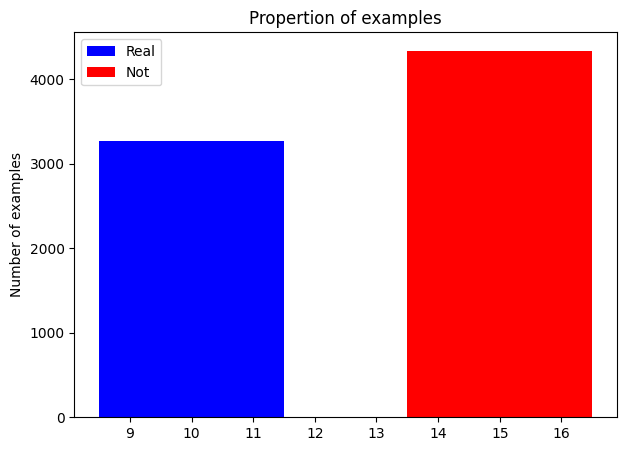

In [ ]:
# extracting the number of examples of each class
Real_len = tweet[tweet['target'] == 1].shape[0]
Not_len = tweet[tweet['target'] == 0].shape[0]
# bar plot of the 3 classes
plt.rcParams['figure.figsize'] = (7, 5)
plt.bar(10,Real_len,3, label="Real", color='blue')
plt.bar(15,Not_len,3, label="Not", color='red')
plt.legend()
plt.ylabel('Number of examples')
plt.title('Propertion of examples')
plt.show()

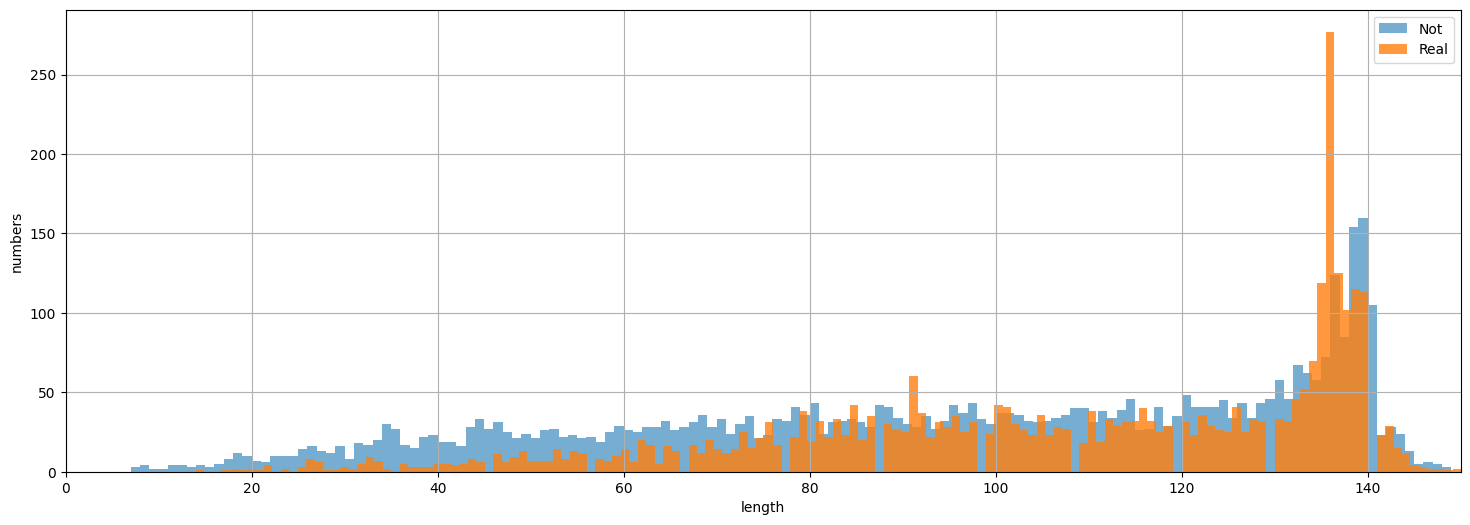

In [ ]:
def length(text):
    '''a function which returns the length of text'''
    return len(text)
tweet['length'] = tweet['text'].apply(length)
plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 150
plt.hist(tweet[tweet['target'] == 0]['length'], alpha = 0.6, bins=bins, label='Not')
plt.hist(tweet[tweet['target'] == 1]['length'], alpha = 0.8, bins=bins, label='Real')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,150)
plt.grid()
plt.show()

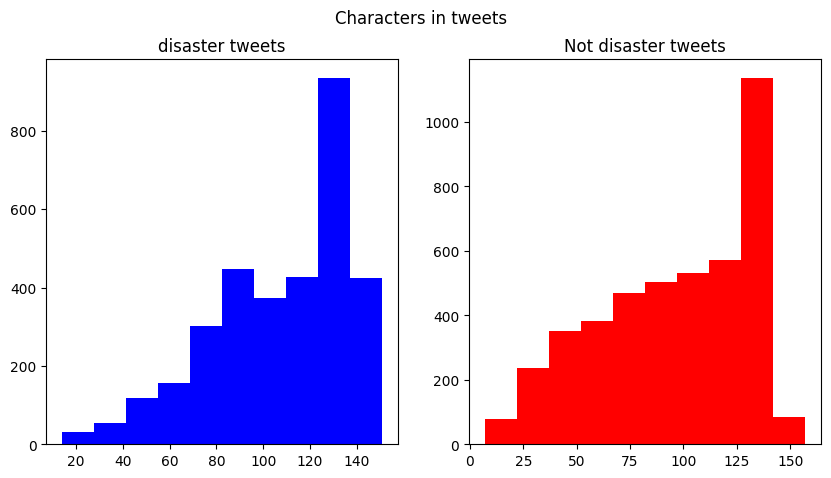

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweet[tweet['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='blue')
ax1.set_title('disaster tweets')
tweet_len=tweet[tweet['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='red')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

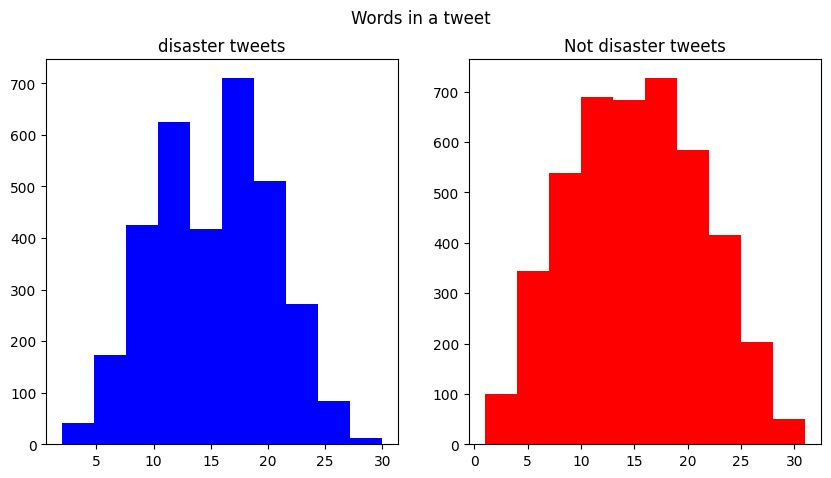

In [ ]:
#Number of words in a tweet
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweet[tweet['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='blue')
ax1.set_title('disaster tweets')
tweet_len=tweet[tweet['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='red')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

<ipython-input-29-8ec8bc10c90c>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='blue')
<ipython-input-29-8ec8bc10c90c>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='red')


Text(0.5, 0.98, 'Average word length in each tweet')

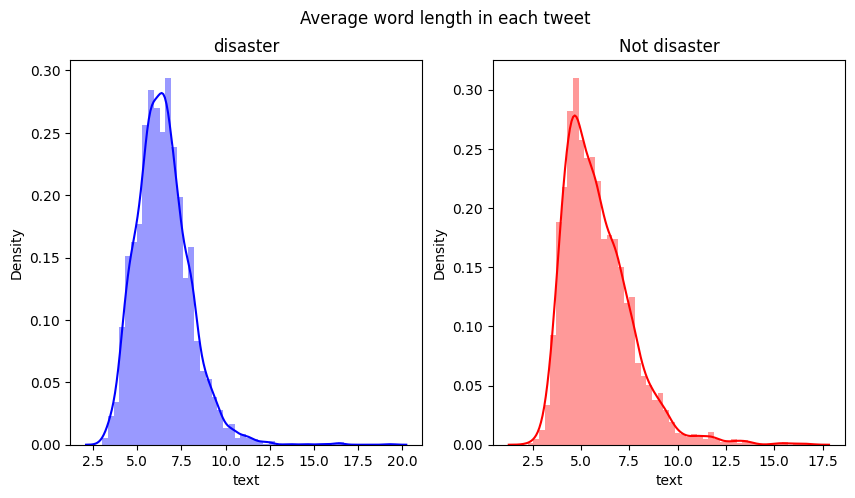

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=tweet[tweet['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='blue')
ax1.set_title('disaster')
word=tweet[tweet['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='red')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

In [ ]:
def create_corpus(target):
    corpus=[]

    for x in tweet[tweet['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

def create_corpus_df(tweet, target):
    corpus=[]

    for x in tweet[tweet['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

#Common stopwords in tweets
#First we will analyze tweets with class 0.

corpus=create_corpus(0)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
np.array(stop)

array({"it's", 'that', 's', 'won', 'couldn', 'his', 'did', 'very', "wasn't", 'our', 'an', 'all', 'isn', 'll', "doesn't", 'over', 'do', 'doesn', 'which', 'had', 'these', 'were', "needn't", 'whom', 'ourselves', 'was', 'there', 'when', 'wasn', "that'll", 'being', 'they', 'down', 'd', 'any', 'mightn', 've', 'haven', 'to', 'theirs', 'through', 'few', 'himself', "shan't", "you'd", 'he', "she's", 'during', 'further', 'then', 'where', 'against', "mustn't", 'ma', 'this', 'by', 'but', 'out', 'are', 'before', 'them', 'at', 'no', 'him', 'y', "you've", 'doing', 'into', 'we', 'and', 'with', 'each', 'didn', 'not', 'than', 'shan', "couldn't", 'the', "shouldn't", "haven't", 'its', 'ain', 'it', 'myself', 'because', 'you', 'why', 'does', 'is', 'such', 'who', "wouldn't", 'herself', 'most', 'their', 'too', "hadn't", 'for', 'other', 'both', 'a', 'nor', 'ours', 'don', 'just', 'so', 're', 'having', 'about', 'if', 'have', 'my', 'her', 'themselves', 'here', 'once', "weren't", 'until', 'yours', "hasn't", 'mustn'

<BarContainer object of 18 artists>

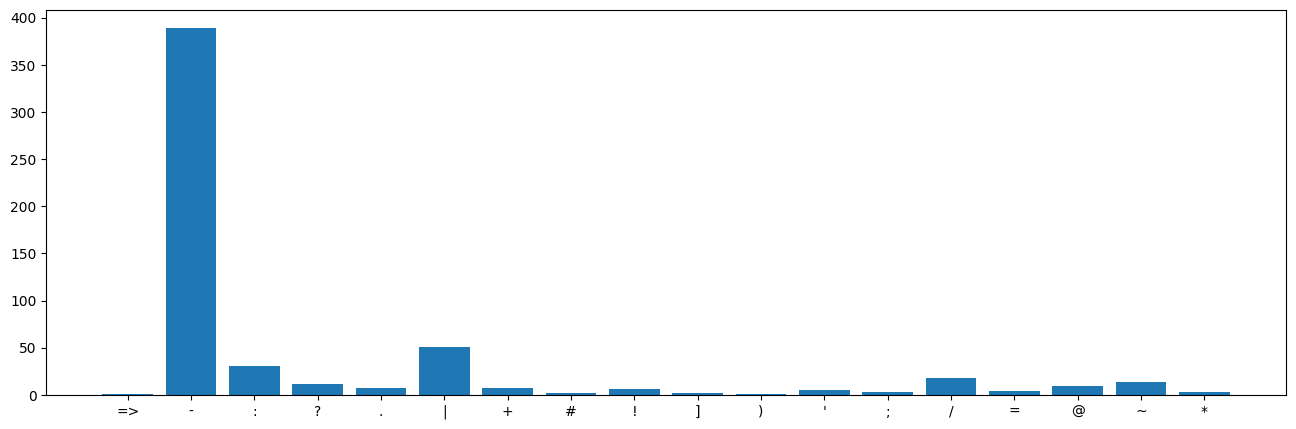

In [ ]:
#check tweets indicating real disaste
plt.figure(figsize=(16,5))
corpus=create_corpus(1)

dic=defaultdict(int)
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1

x,y=zip(*dic.items())
plt.bar(x,y)

<BarContainer object of 20 artists>

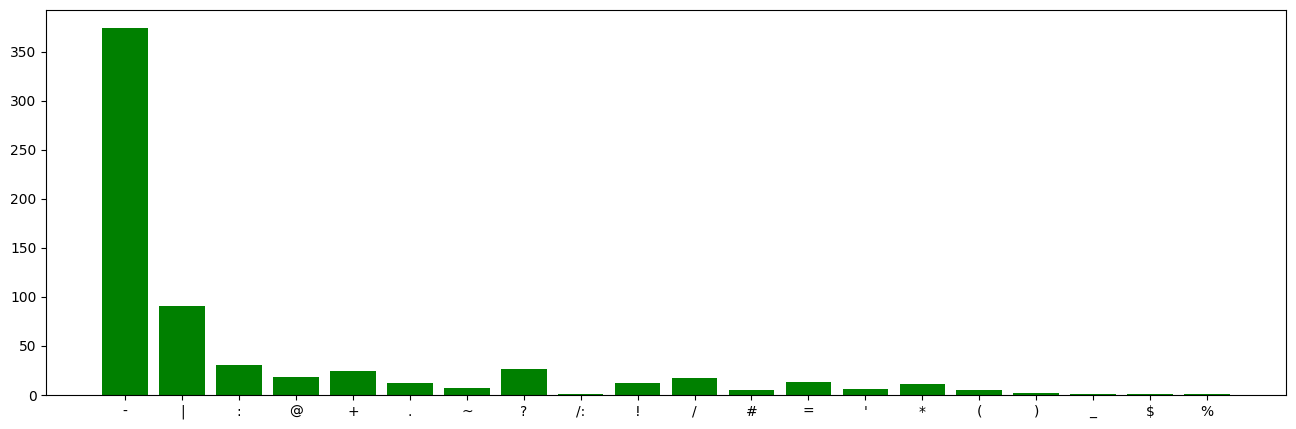

In [ ]:
#we will move on to class 0.
plt.figure(figsize=(16,5))
corpus=create_corpus(0)
dic=defaultdict(int)
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1

x,y=zip(*dic.items())
plt.bar(x,y,color='green')

In [ ]:
corpus_new1=create_corpus_df(tweet,1)
len(corpus_new1)
corpus_new1[:10]

['Our',
 'Deeds',
 'are',
 'the',
 'Reason',
 'of',
 'this',
 '#earthquake',
 'May',
 'ALLAH']

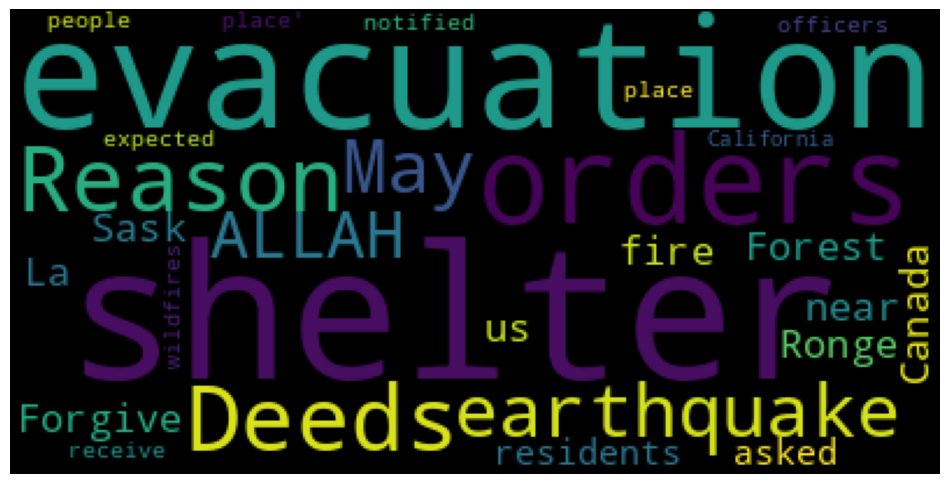

In [ ]:
# Generating the wordcloud with the values under the category dataframe
from nltk.util import ngrams
from wordcloud import WordCloud

plt.figure(figsize=(12,8))
word_cloud = WordCloud(
                          background_color='black',
                          max_font_size = 80
                         ).generate(" ".join(corpus_new1[:50]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

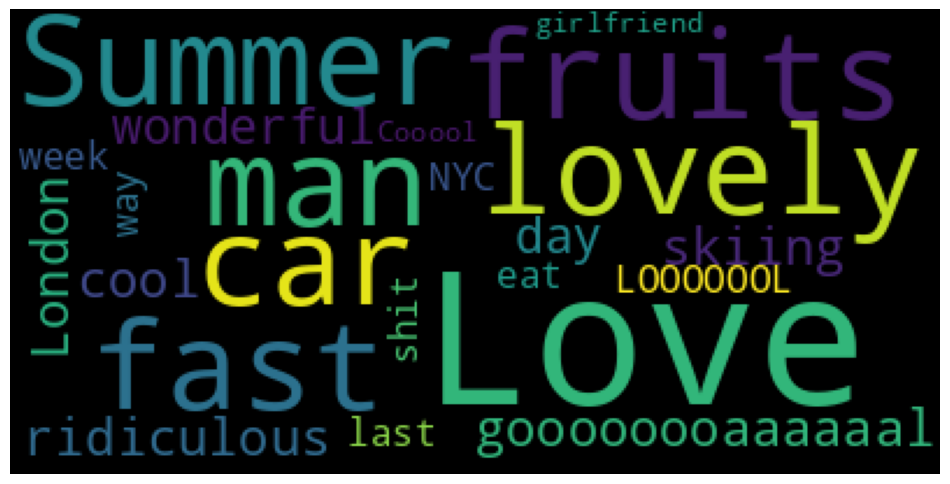

In [ ]:
corpus_new0=create_corpus_df(tweet,0)
len(corpus_new0)
corpus_new0[:10]
# Generating the wordcloud with the values under the category dataframe
plt.figure(figsize=(12,8))
word_cloud = WordCloud(
                          background_color='black',
                          max_font_size = 80
                         ).generate(" ".join(corpus_new0[:50]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

#Bag of Word Counts


Weighted Words - Bag of Words (BoW) - Bag of n-grams:
N-gram is a sequence that contains n-elements (characters, words, etc). A single word such a "apple", "orange" is a Uni-gram; hence, "red apple" "big orange" is bi-gram and "red ripped apple", "big orange bag" is tri-gram.
Bags of words: Vectors of word counts or frequencies
Bags of n-grams: Counts of word pairs (bigrams), triplets (trigrams), and so on
The bag-of-words/ bag-of-n-gram model is a reduced and simpliﬁed representation of a text document from selected parts of the text, based on speciﬁc criteria, such as word frequency.

In a BoW, a body of text, such as a document or a sentence, is thought of like a bag of words. Lists of words are created in the BoW process. These words in a matrix are not sentences which structure sentences and grammar, and the semantic relationship between these words are ignored in their collection and construction. The words are often representative of the content of a sentence. While grammar and order of appearance are ignored, multiplicity is counted and may be used later to determine the focus points of the documents.

Example: Document

“As the home to UVA’s recognized undergraduate and graduate degree programs in systems engineering. In the UVA Department of Systems and Information Engineering, our students are exposed to a wide range of range”

Bag-of-Words (BoW): {“As”, “the”, “home”, “to”, “UVA’s”, “recognized”, “undergraduate”, “and”, “graduate”, “degree”, “program”, “in”, “systems”, “engineering”, “in”, “Department”, “Information”,“students”, “ ”,“are”, “exposed”, “wide”, “range” }

Bag-of-Feature (BoF) Feature = {1,1,1,3,2,1,2,1,2,3,1,1,1,2,1,1,1,1,1,1}

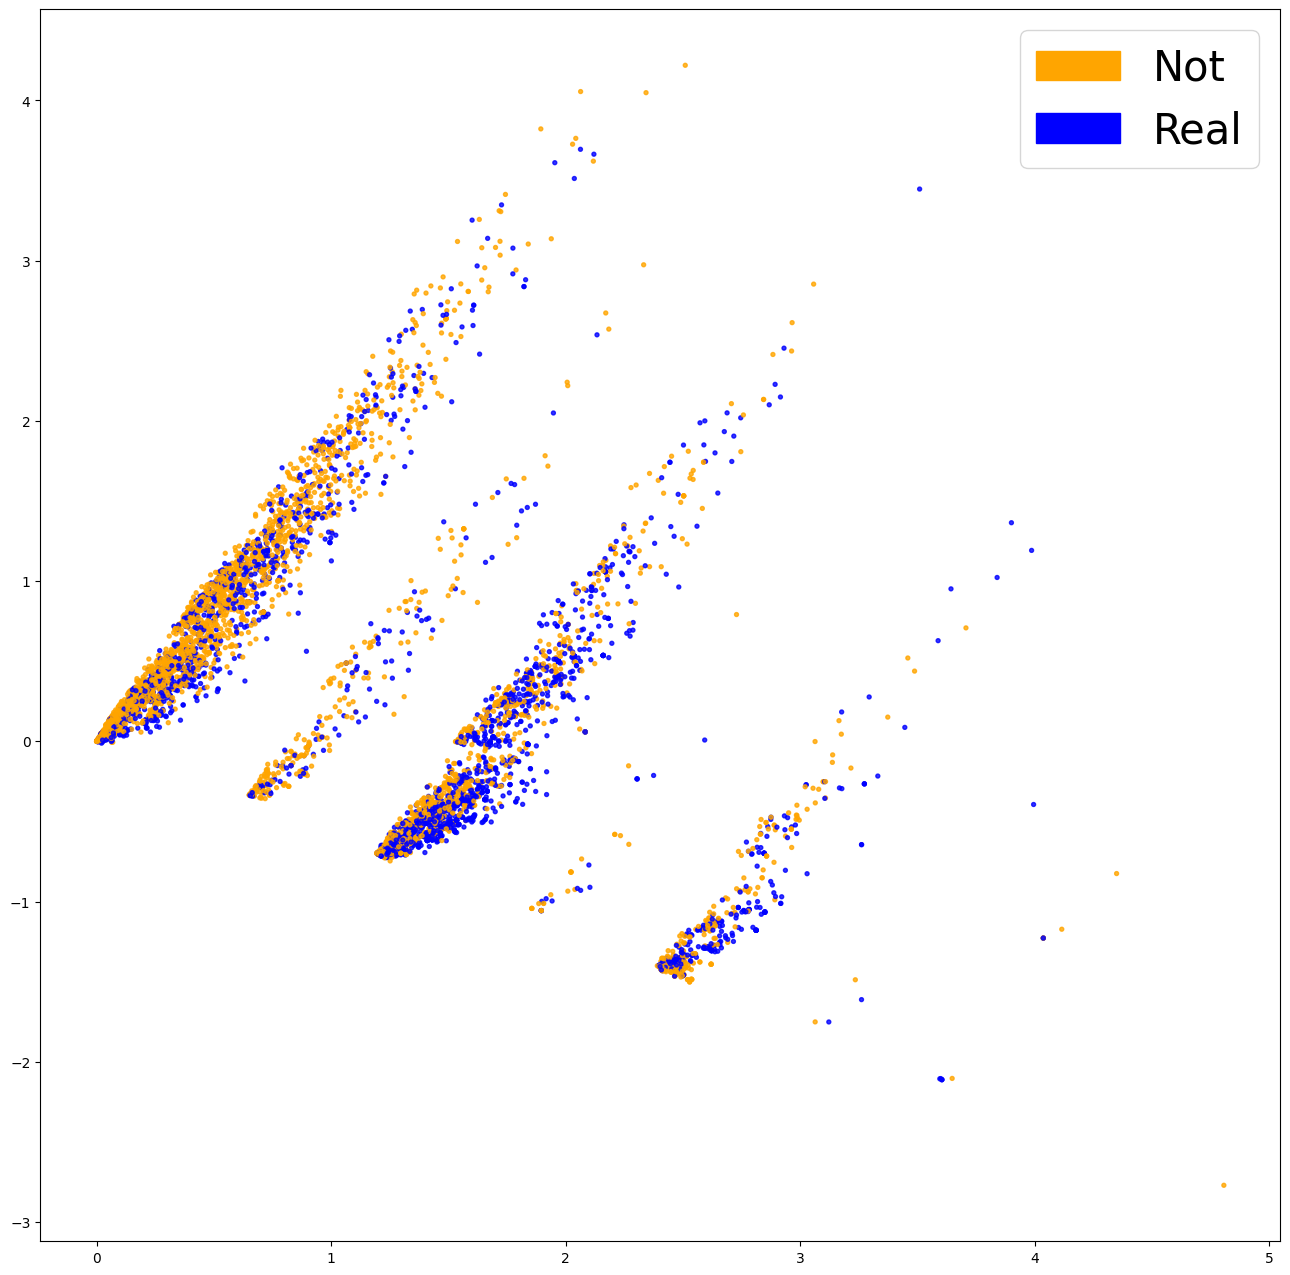

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.patches as mpatches
import matplotlib
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

random_state_split = 42
Dropout_num = 0
learning_rate = 5.95e-6
valid = 0.15
epochs_num = 3
batch_size_num = 16
target_corrected = False
target_big_corrected = False

def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

list_corpus = tweet["text"].tolist()
list_labels = tweet["target"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2,
                                                                                random_state=random_state_split)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            orange_patch = mpatches.Patch(color='orange', label='Not')
            blue_patch = mpatches.Patch(color='blue', label='Real')
            plt.legend(handles=[orange_patch, blue_patch], prop={'size': 30})

fig = plt.figure(figsize=(16, 16))
plot_LSA(X_train_counts, y_train)
plt.show()

In [ ]:
tweet.head(10)

Unnamed: 0  id keyword location  \
0           0   1     NaN      NaN   
1           1   4     NaN      NaN   
2           2   5     NaN      NaN   
3           3   6     NaN      NaN   
4           4   7     NaN      NaN   
5           5   8     NaN      NaN   
6           6  10     NaN      NaN   
7           7  13     NaN      NaN   
8           8  14     NaN      NaN   
9           9  15     NaN      NaN   

                                                text  target  \
0  Our Deeds are the Reason of this #earthquake M...       1   
1             Forest fire near La Ronge Sask. Canada       1   
2  All residents asked to 'shelter in place' are ...       1   
3  13,000 people receive #wildfires evacuation or...       1   
4  Just got sent this photo from Ruby #Alaska as ...       1   
5  #RockyFire Update => California Hwy. 20 closed...       1   
6  #flood #disaster Heavy rain causes flash flood...       1   
7  I'm on top of the hill and I can see a fire in...       1   
8  There's an emergency evacuation happening now ...       1   
9  I'm afraid that the tornado is coming to our a...       1   

                                               tweet  \
0   Our Deeds are the Reason of this #earthquake ...   
1             Forest fire near La Ronge Sask. Canada   
2   All residents asked to 'shelter in place' are...   
3   13,000 people receive #wildfires evacuation o...   
4   Just got sent this photo from Ruby #Alaska as...   
5   #RockyFire Update => California Hwy. 20 close...   
6   #flood #disaster Heavy rain causes flash floo...   
7   I'm on top of the hill and I can see a fire i...   
8   There's an emergency evacuation happening now...   
9   I'm afraid that the tornado is coming to our ...   

                                         tweet_lower  \
0   our deeds are the reason of this #earthquake ...   
1             forest fire near la ronge sask. canada   
2   all residents asked to 'shelter in place' are...   
3   13,000 people receive #wildfires evacuation o...   
4   just got sent this photo from ruby #alaska as...   
5   #rockyfire update => california hwy. 20 close...   
6   #flood #disaster heavy rain causes flash floo...   
7   i'm on top of the hill and i can see a fire i...   
8   there's an emergency evacuation happening now...   
9   i'm afraid that the tornado is coming to our ...   

                                        tweet_noHTML  \
0  our deeds are the reason of this #earthquake m...   
1             forest fire near la ronge sask. canada   
2  all residents asked to 'shelter in place' are ...   
3  13,000 people receive #wildfires evacuation or...   
4  just got sent this photo from ruby #alaska as ...   
5  #rockyfire update => california hwy. 20 closed...   
6  #flood #disaster heavy rain causes flash flood...   
7  i'm on top of the hill and i can see a fire in...   
8  there's an emergency evacuation happening now ...   
9  i'm afraid that the tornado is coming to our a...   

                                tweet_noContractions  ...  \
0  our deeds are the reason of this #earthquake m...  ...   
1             forest fire near la ronge sask. canada  ...   
2  all residents asked to 'shelter in place' are ...  ...   
3  13,000 people receive #wildfires evacuation or...  ...   
4  just got sent this photo from ruby #alaska as ...  ...   
5  #rockyfire update => california hwy. 20 closed...  ...   
6  #flood #disaster heavy rain causes flash flood...  ...   
7  i am on top of the hill and i can see a fire i...  ...   
8  there is an emergency evacuation happening now...  ...   
9  i am afraid that the tornado is coming to our ...  ...   

                                     tweet_noUnicode  \
0  our deeds are the reason of this #earthquake m...   
1             forest fire near la ronge sask. canada   
2  all residents asked to 'shelter in place' are ...   
3  13,000 people receive #wildfires evacuation or...   
4  just got sent this photo from ruby #alaska as ...   
5  #rockyfire update

#N-gram analysis

In [ ]:
#we will do a bigram (n=2) analysis over the tweets. Let's check the most common bigrams in tweets.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

<Axes: >

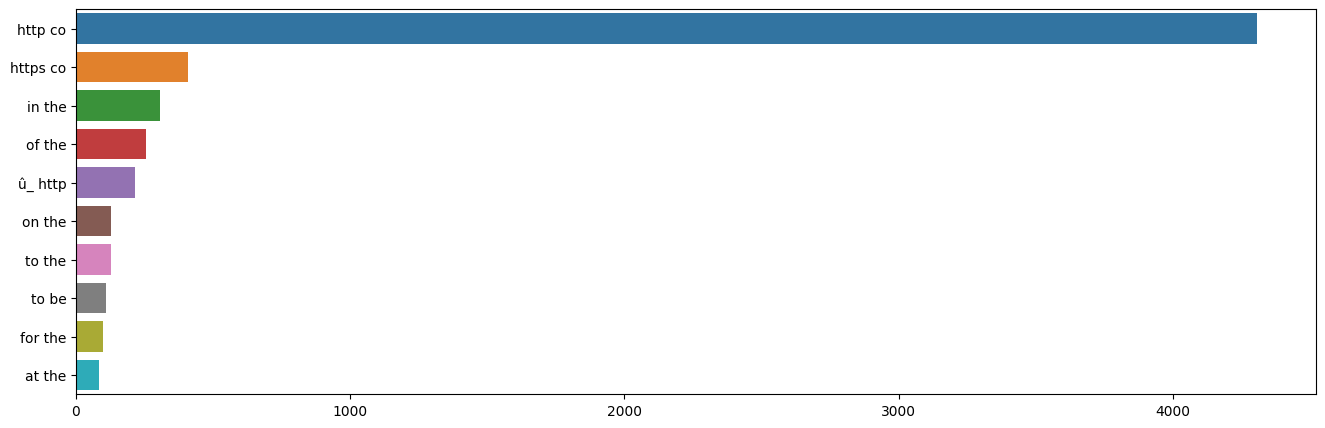

In [ ]:
plt.figure(figsize=(16,5))
top_tweet_bigrams=get_top_tweet_bigrams(tweet['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

#Advanced EDA

```
# word_count
tweet['word_count'] = tweet['text'].apply(lambda x: len(str(x).split()))
df_test['word_count'] = df_test['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
tweet['unique_word_count'] = tweet['text'].apply(lambda x: len(set(str(x).split())))
df_test['unique_word_count'] = df_test['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
tweet['stop_word_count'] = tweet['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
df_test['stop_word_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
tweet['url_count'] = tweet['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
df_test['url_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
tweet['mean_word_length'] = tweet['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
df_test['mean_word_length'] = df_test['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
tweet['char_count'] = tweet['text'].apply(lambda x: len(str(x)))
df_test['char_count'] = df_test['text'].apply(lambda x: len(str(x)))

# punctuation_count
tweet['punctuation_count'] = tweet['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
df_test['punctuation_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
tweet['hashtag_count'] = tweet['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
df_test['hashtag_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
tweet['mention_count'] = tweet['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
df_test['mention_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
```
All of the meta features have very similar distributions in training and test set which also proves that training and test set are taken from the same sample.

All of the meta features have information about target as well, but some of them are not good enough such as url_count, hashtag_count and mention_count.

On the other hand, word_count, unique_word_count, stop_word_count, mean_word_length, char_count, punctuation_count have very different distributions for disaster and non-disaster tweets. Those features might be useful in models

```
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']
DISASTER_TWEETS = tweet['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(tweet.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green')
    sns.distplot(tweet.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red')

    sns.distplot(tweet[feature], label='Training', ax=axes[i][1])
    sns.distplot(df_test[feature], label='Test', ax=axes[i][1])
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()
```



In [ ]:
df_test = pd.read_csv('/content/test.csv')
df_train =  pd.read_csv('/content/train.csv')

from wordcloud import STOPWORDS
# word_count
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
df_test['word_count'] = df_test['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
df_train['unique_word_count'] = df_train['text'].apply(lambda x: len(set(str(x).split())))
df_test['unique_word_count'] = df_test['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
df_train['stop_word_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
df_test['stop_word_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
df_train['url_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
df_test['url_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
df_train['mean_word_length'] = df_train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
df_test['mean_word_length'] = df_test['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
df_test['char_count'] = df_test['text'].apply(lambda x: len(str(x)))

# punctuation_count
df_train['punctuation_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
df_test['punctuation_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
df_train['hashtag_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
df_test['hashtag_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
df_train['mention_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
df_test['mention_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

df_train['target_mean'] = df_train.groupby('keyword')['target'].transform('mean')
df_train.drop(columns=['target_mean'], inplace=True)

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2142: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2142: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2142: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2142: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2142: UserWarning: `displot` is a figure-lev

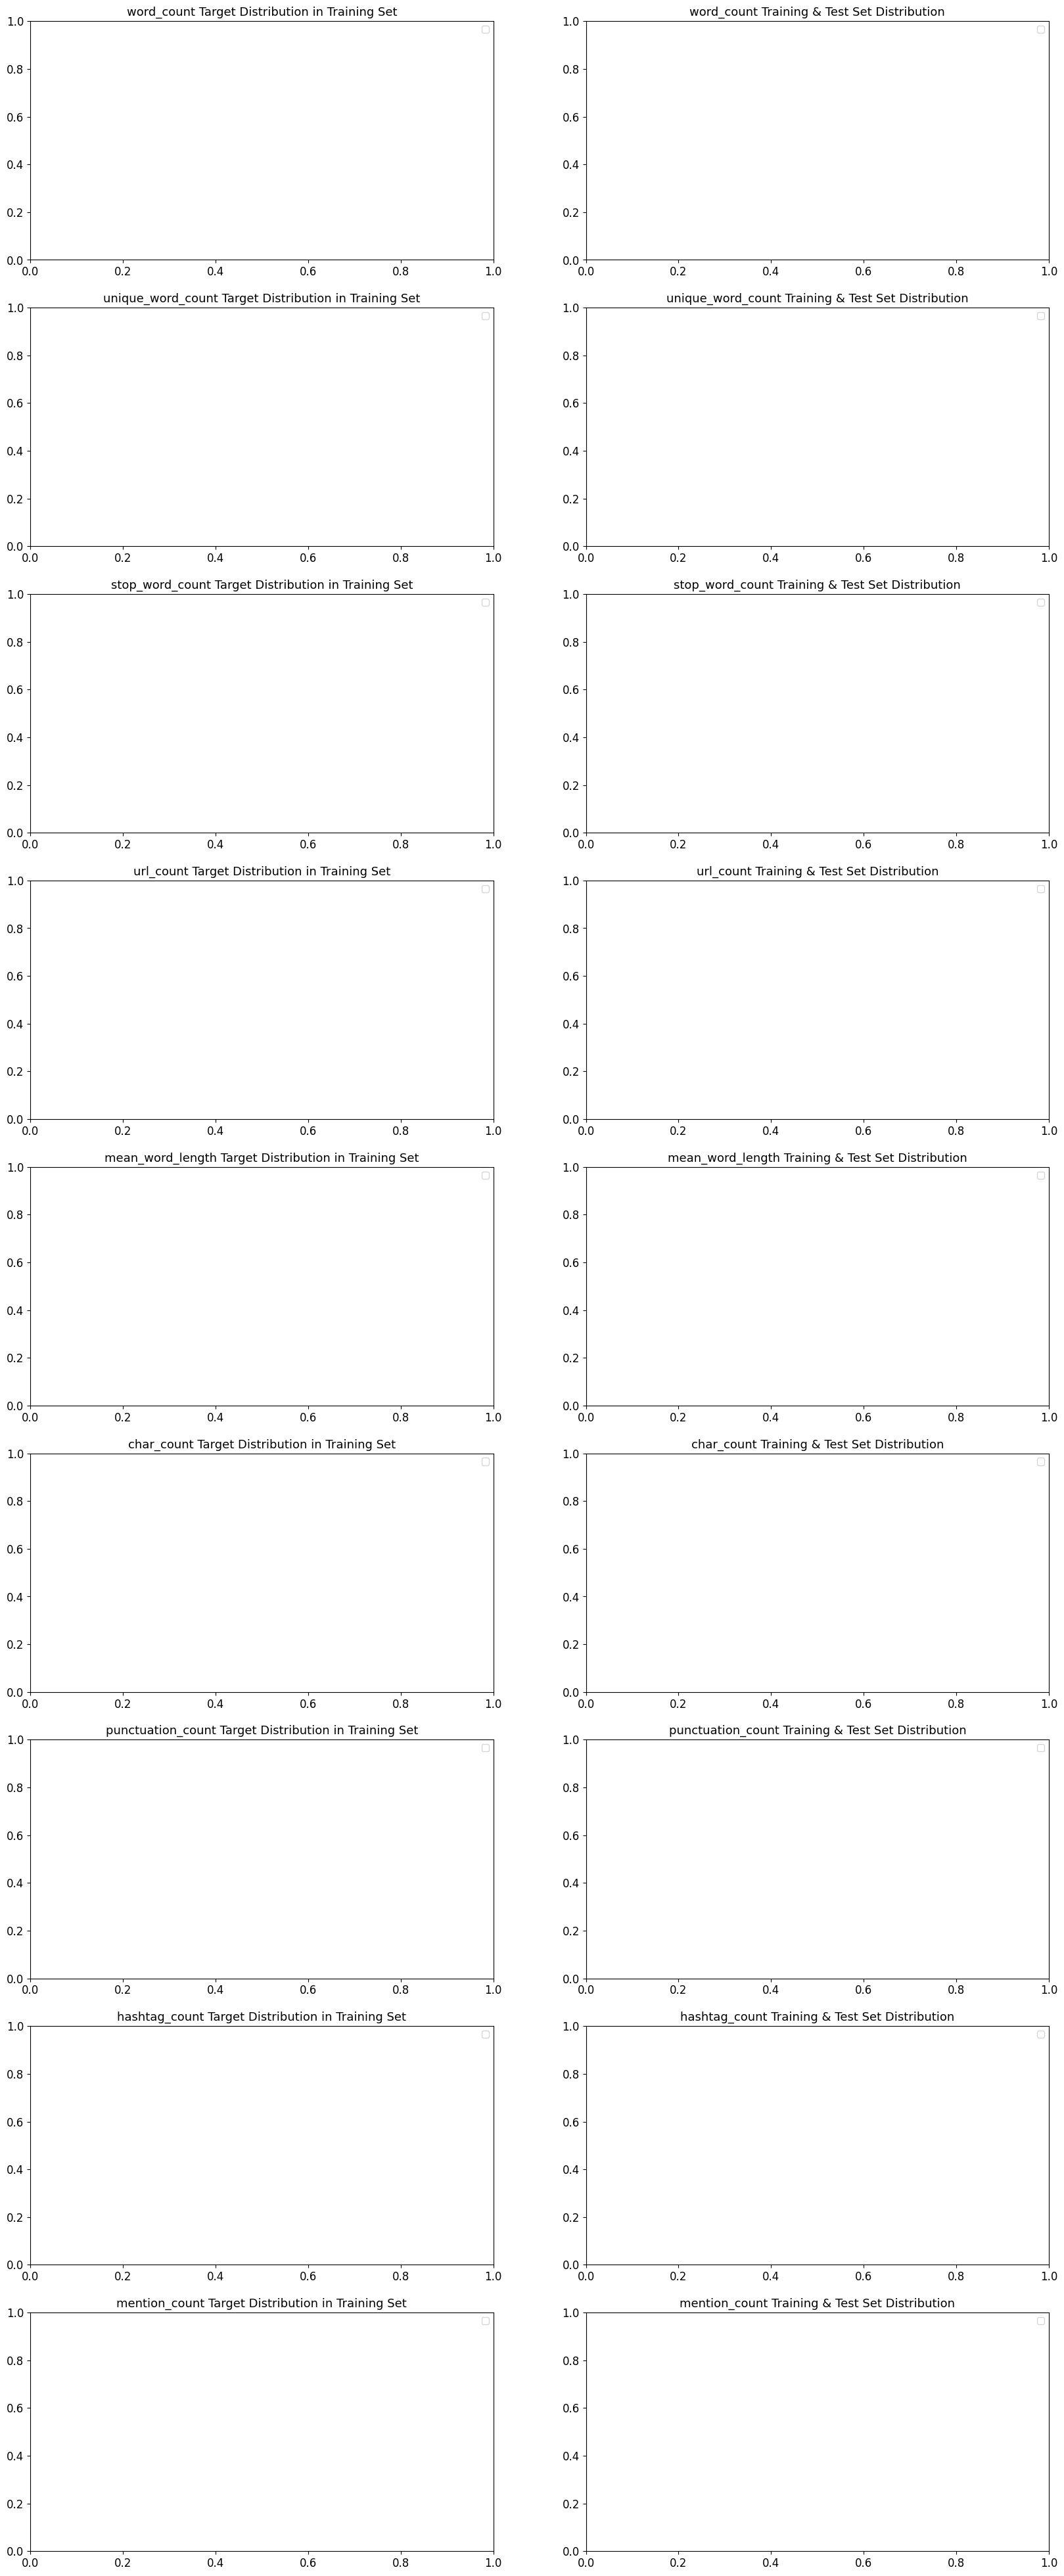

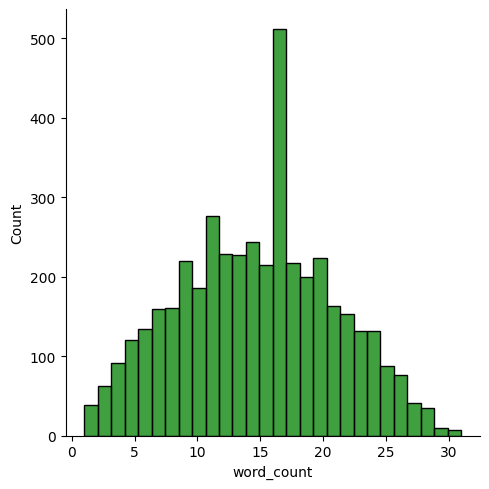

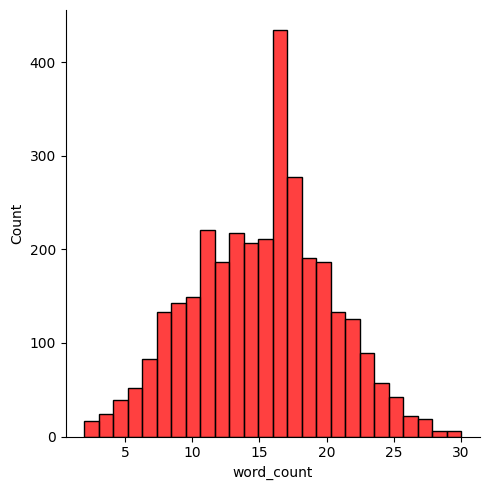

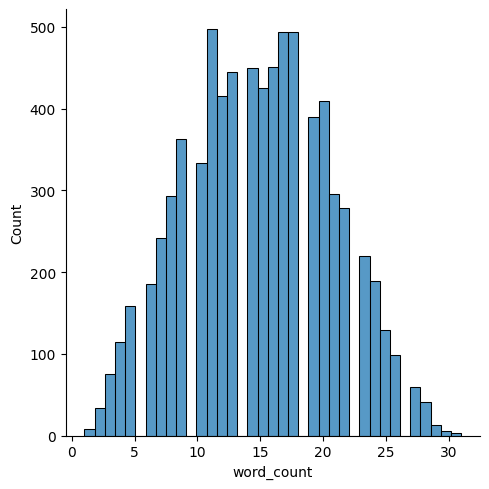

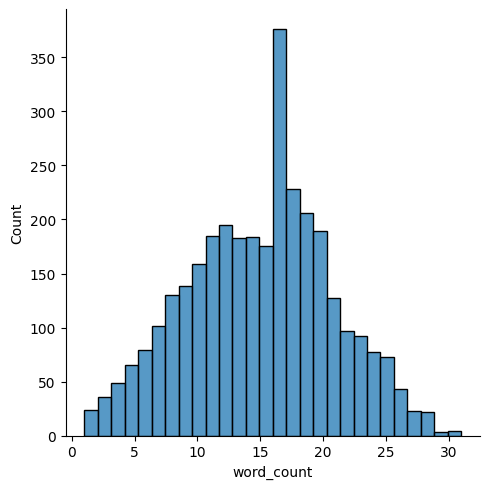

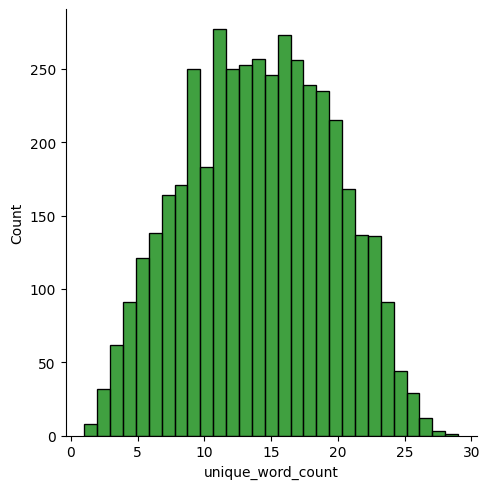

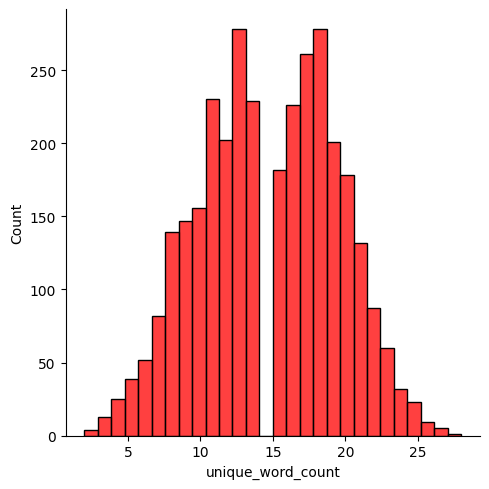

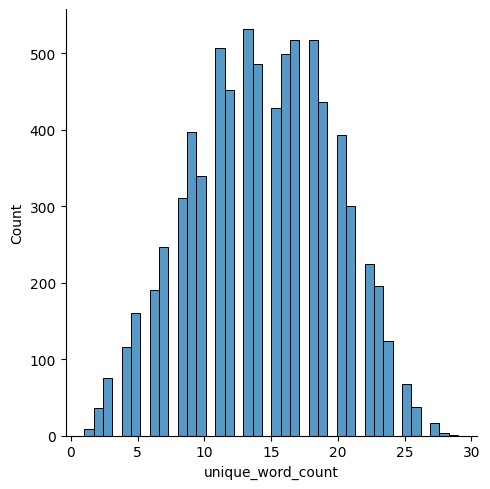

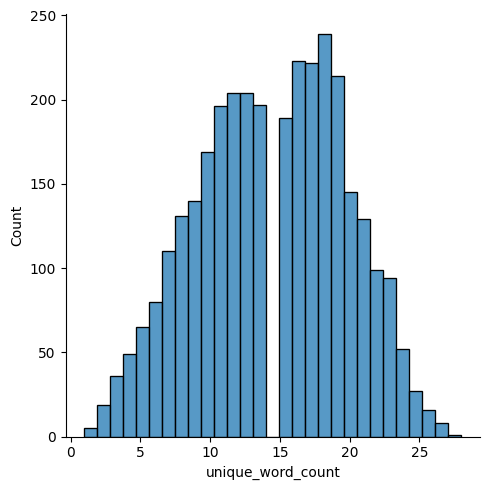

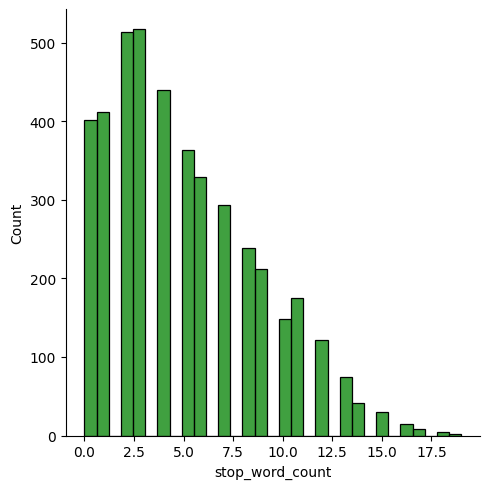

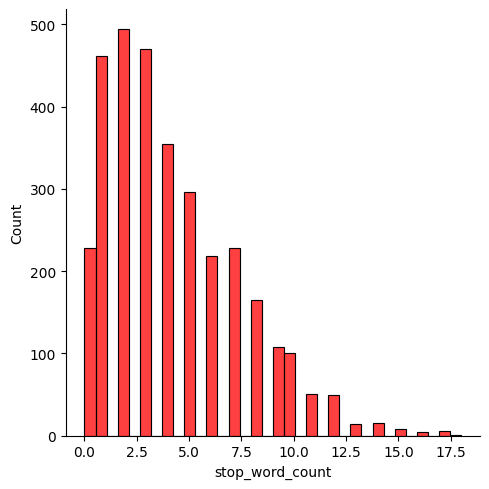

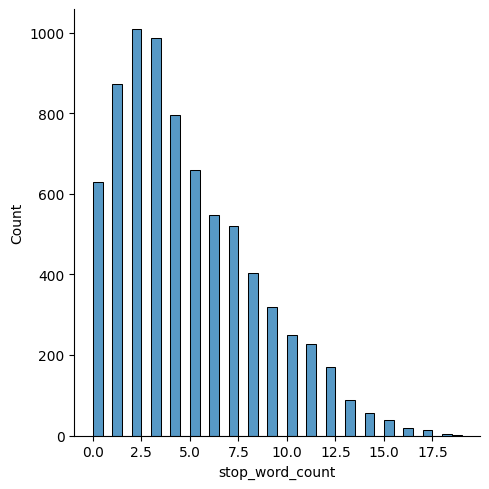

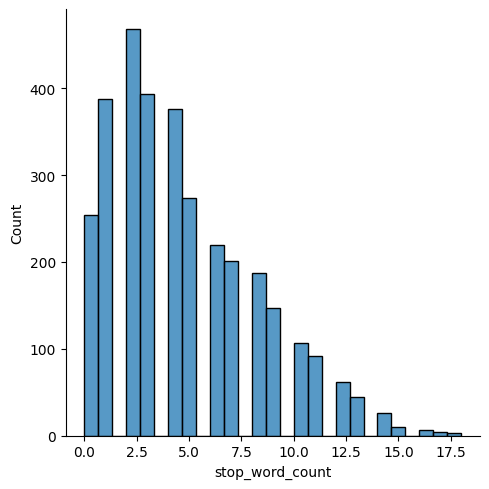

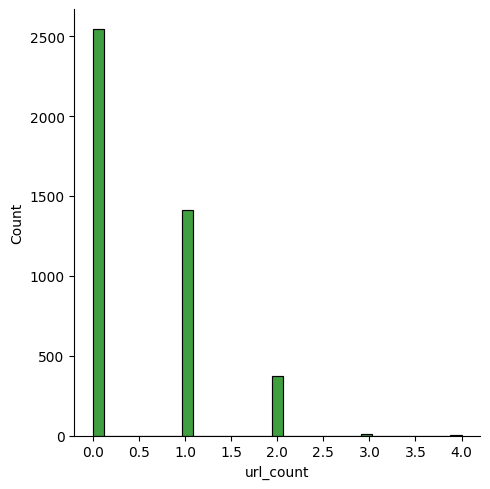

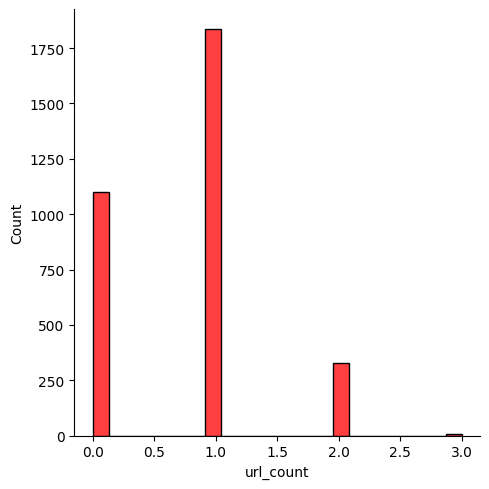

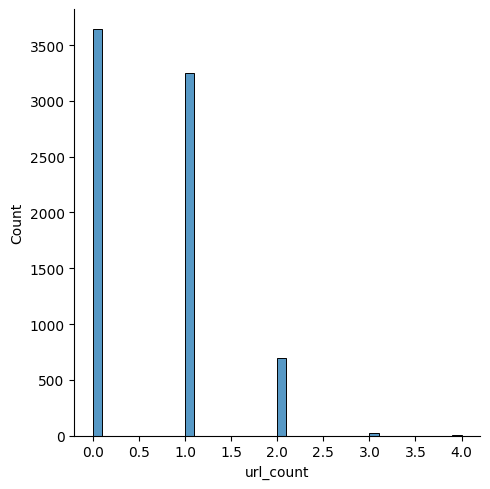

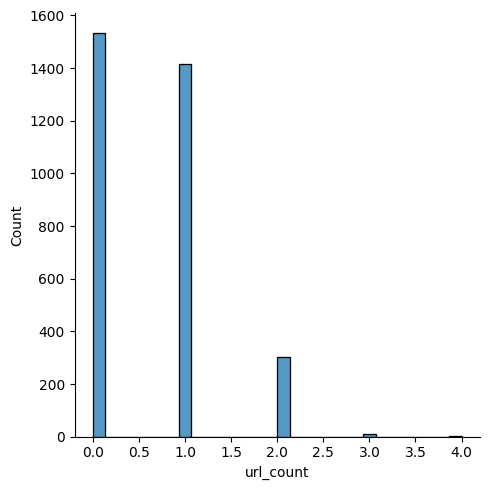

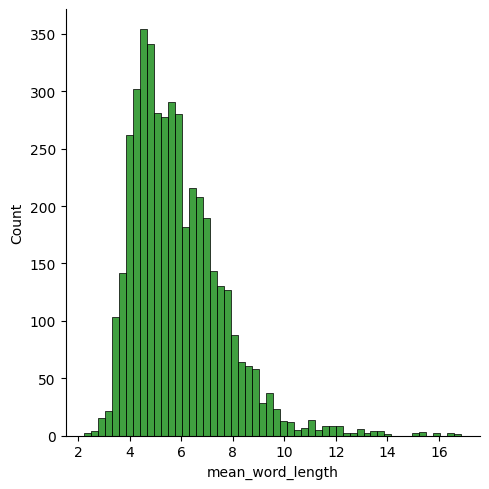

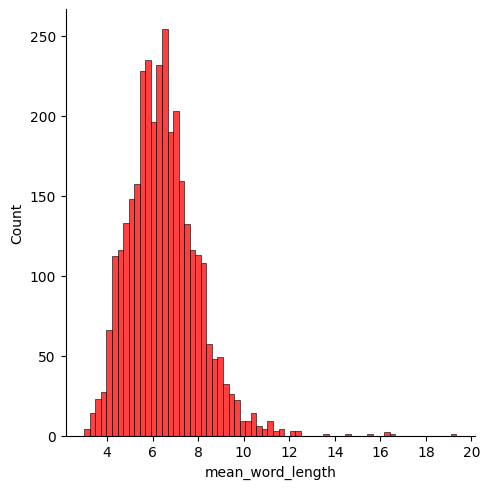

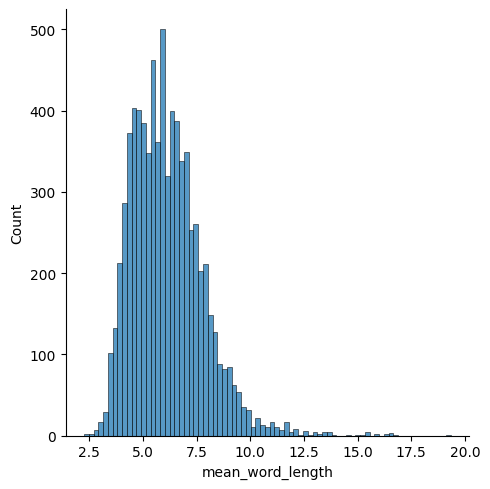

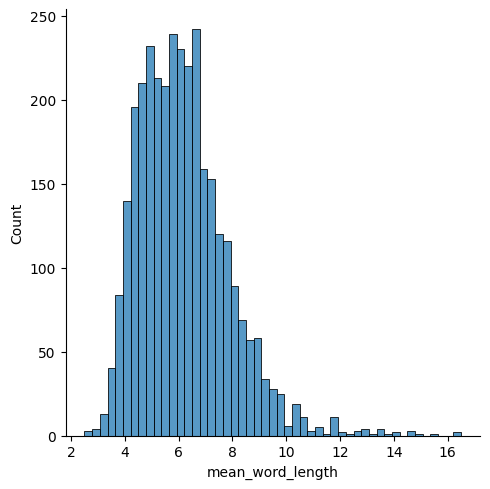

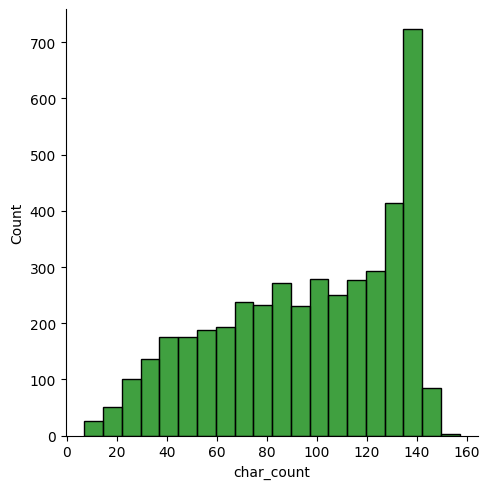

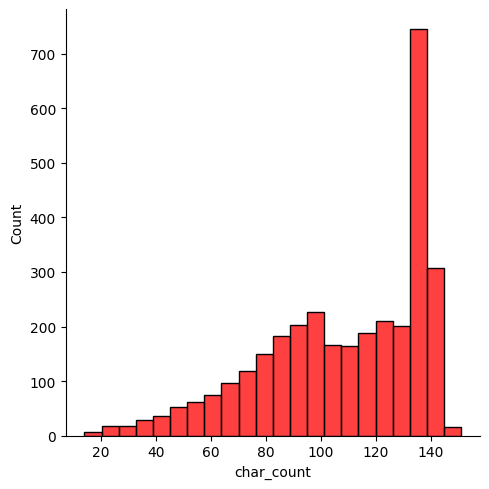

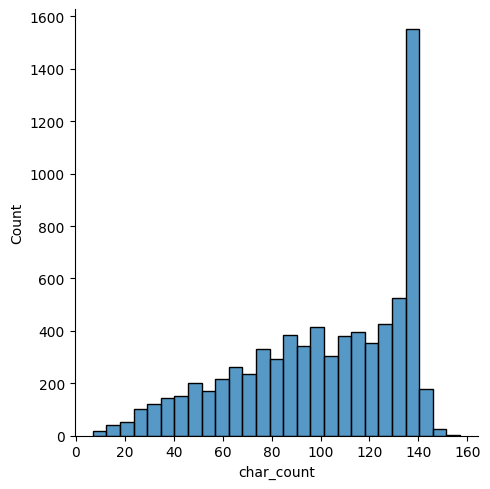

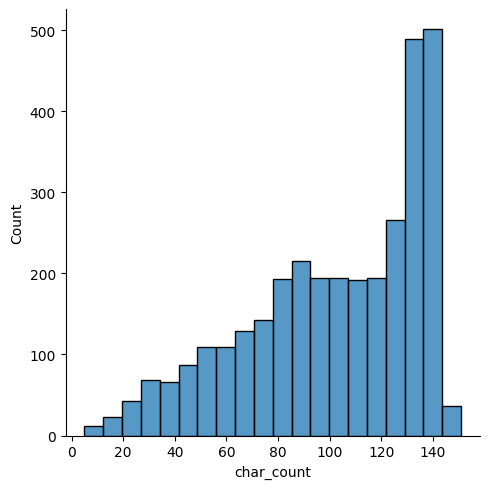

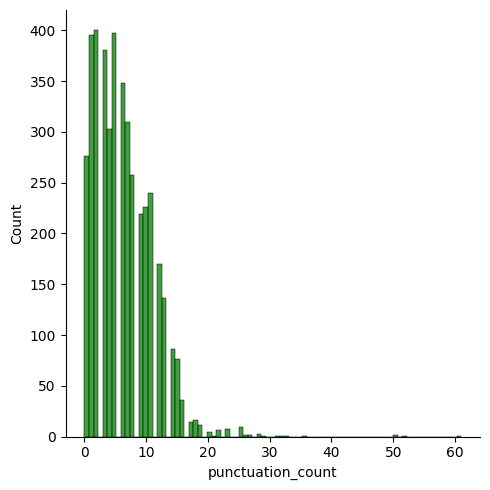

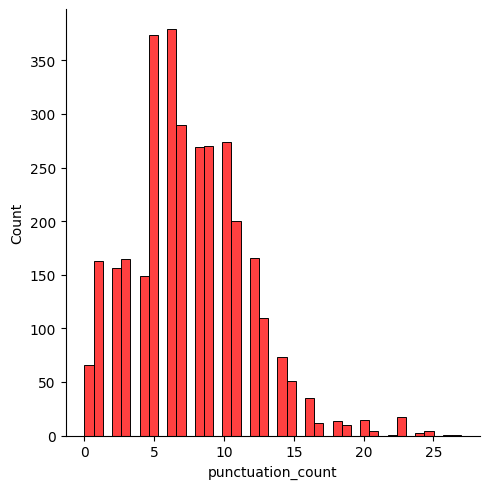

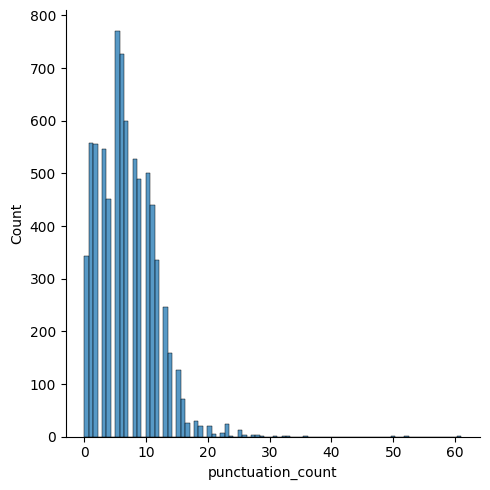

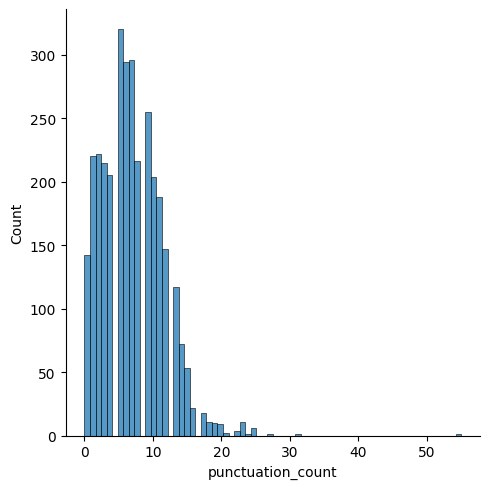

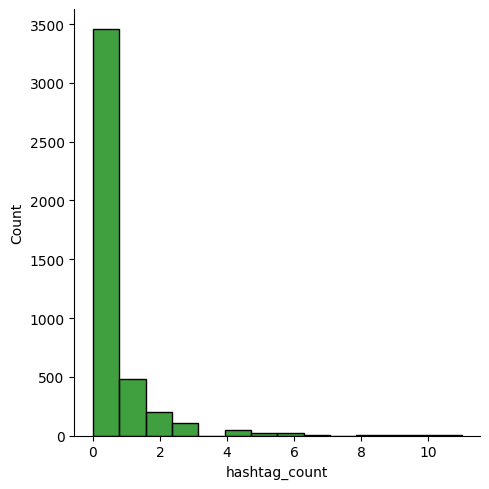

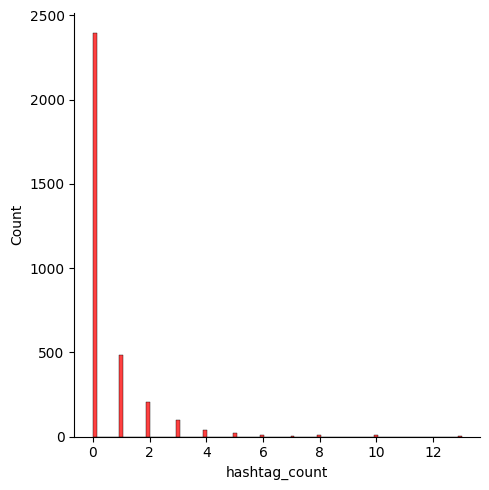

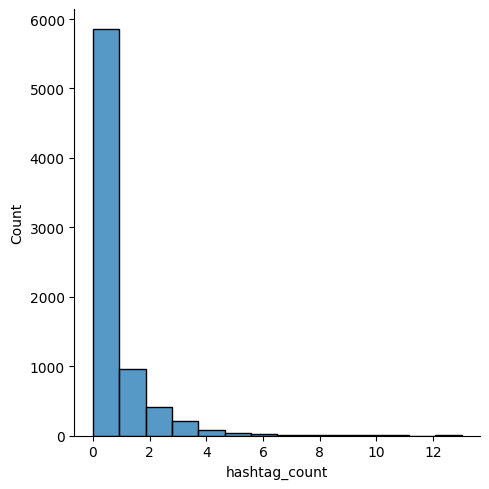

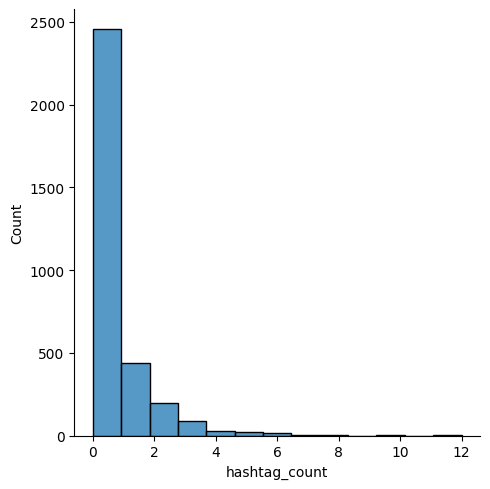

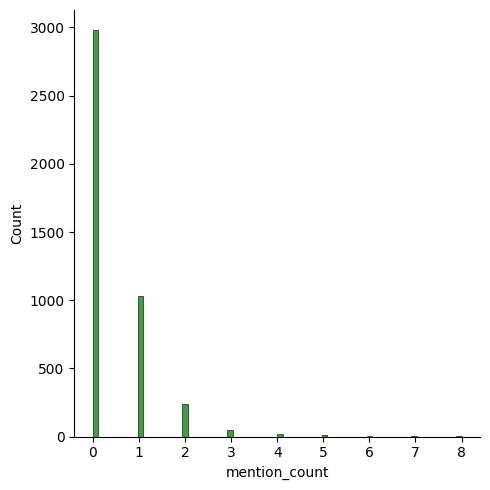

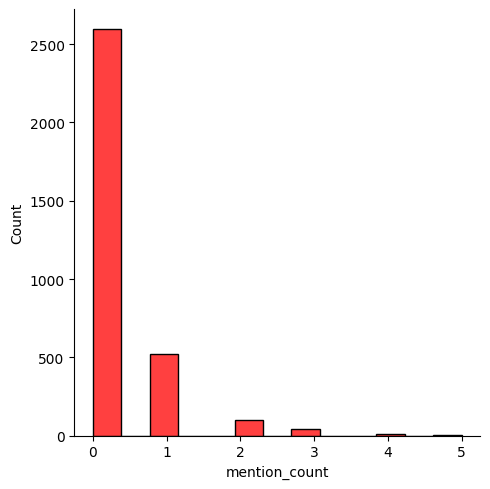

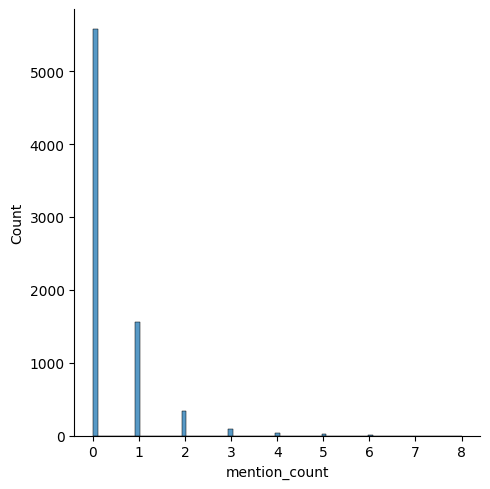

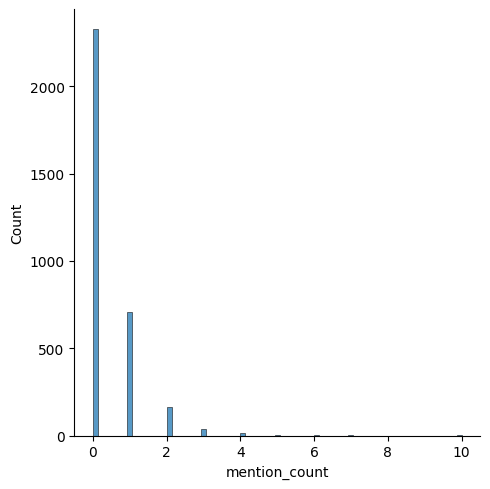

In [ ]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']
DISASTER_TWEETS = df_train['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.displot(df_train.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green')
    sns.displot(df_train.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red')

    sns.displot(df_train[feature], label='Training', ax=axes[i][1])
    sns.displot(df_test[feature], label='Test', ax=axes[i][1])

    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()

    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

In [ ]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]
N = 100

# Unigrams
disaster_unigrams = defaultdict(int)
nondisaster_unigrams = defaultdict(int)

for tweet in df_train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet):
        disaster_unigrams[word] += 1

for tweet in df_train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet):
        nondisaster_unigrams[word] += 1

df_disaster_unigrams = pd.DataFrame(sorted(disaster_unigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_unigrams = pd.DataFrame(sorted(nondisaster_unigrams.items(), key=lambda x: x[1])[::-1])

# Bigrams
disaster_bigrams = defaultdict(int)
nondisaster_bigrams = defaultdict(int)

for tweet in df_train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        disaster_bigrams[word] += 1

for tweet in df_train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        nondisaster_bigrams[word] += 1

df_disaster_bigrams = pd.DataFrame(sorted(disaster_bigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_bigrams = pd.DataFrame(sorted(nondisaster_bigrams.items(), key=lambda x: x[1])[::-1])

# Trigrams
disaster_trigrams = defaultdict(int)
nondisaster_trigrams = defaultdict(int)

for tweet in df_train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        disaster_trigrams[word] += 1

for tweet in df_train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        nondisaster_trigrams[word] += 1

df_disaster_trigrams = pd.DataFrame(sorted(disaster_trigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_trigrams = pd.DataFrame(sorted(nondisaster_trigrams.items(), key=lambda x: x[1])[::-1])

3.2 Unigrams
Most common unigrams exist in both classes are mostly punctuations, stop words or numbers. It is better to clean them before modelling since they don't give much information about target.

Most common unigrams in disaster tweets are already giving information about disasters. It is very hard to use some of those words in other contexts.

Most common unigrams in non-disaster tweets are verbs. This makes sense because most of those sentences have informal active structure since they are coming from individual users.

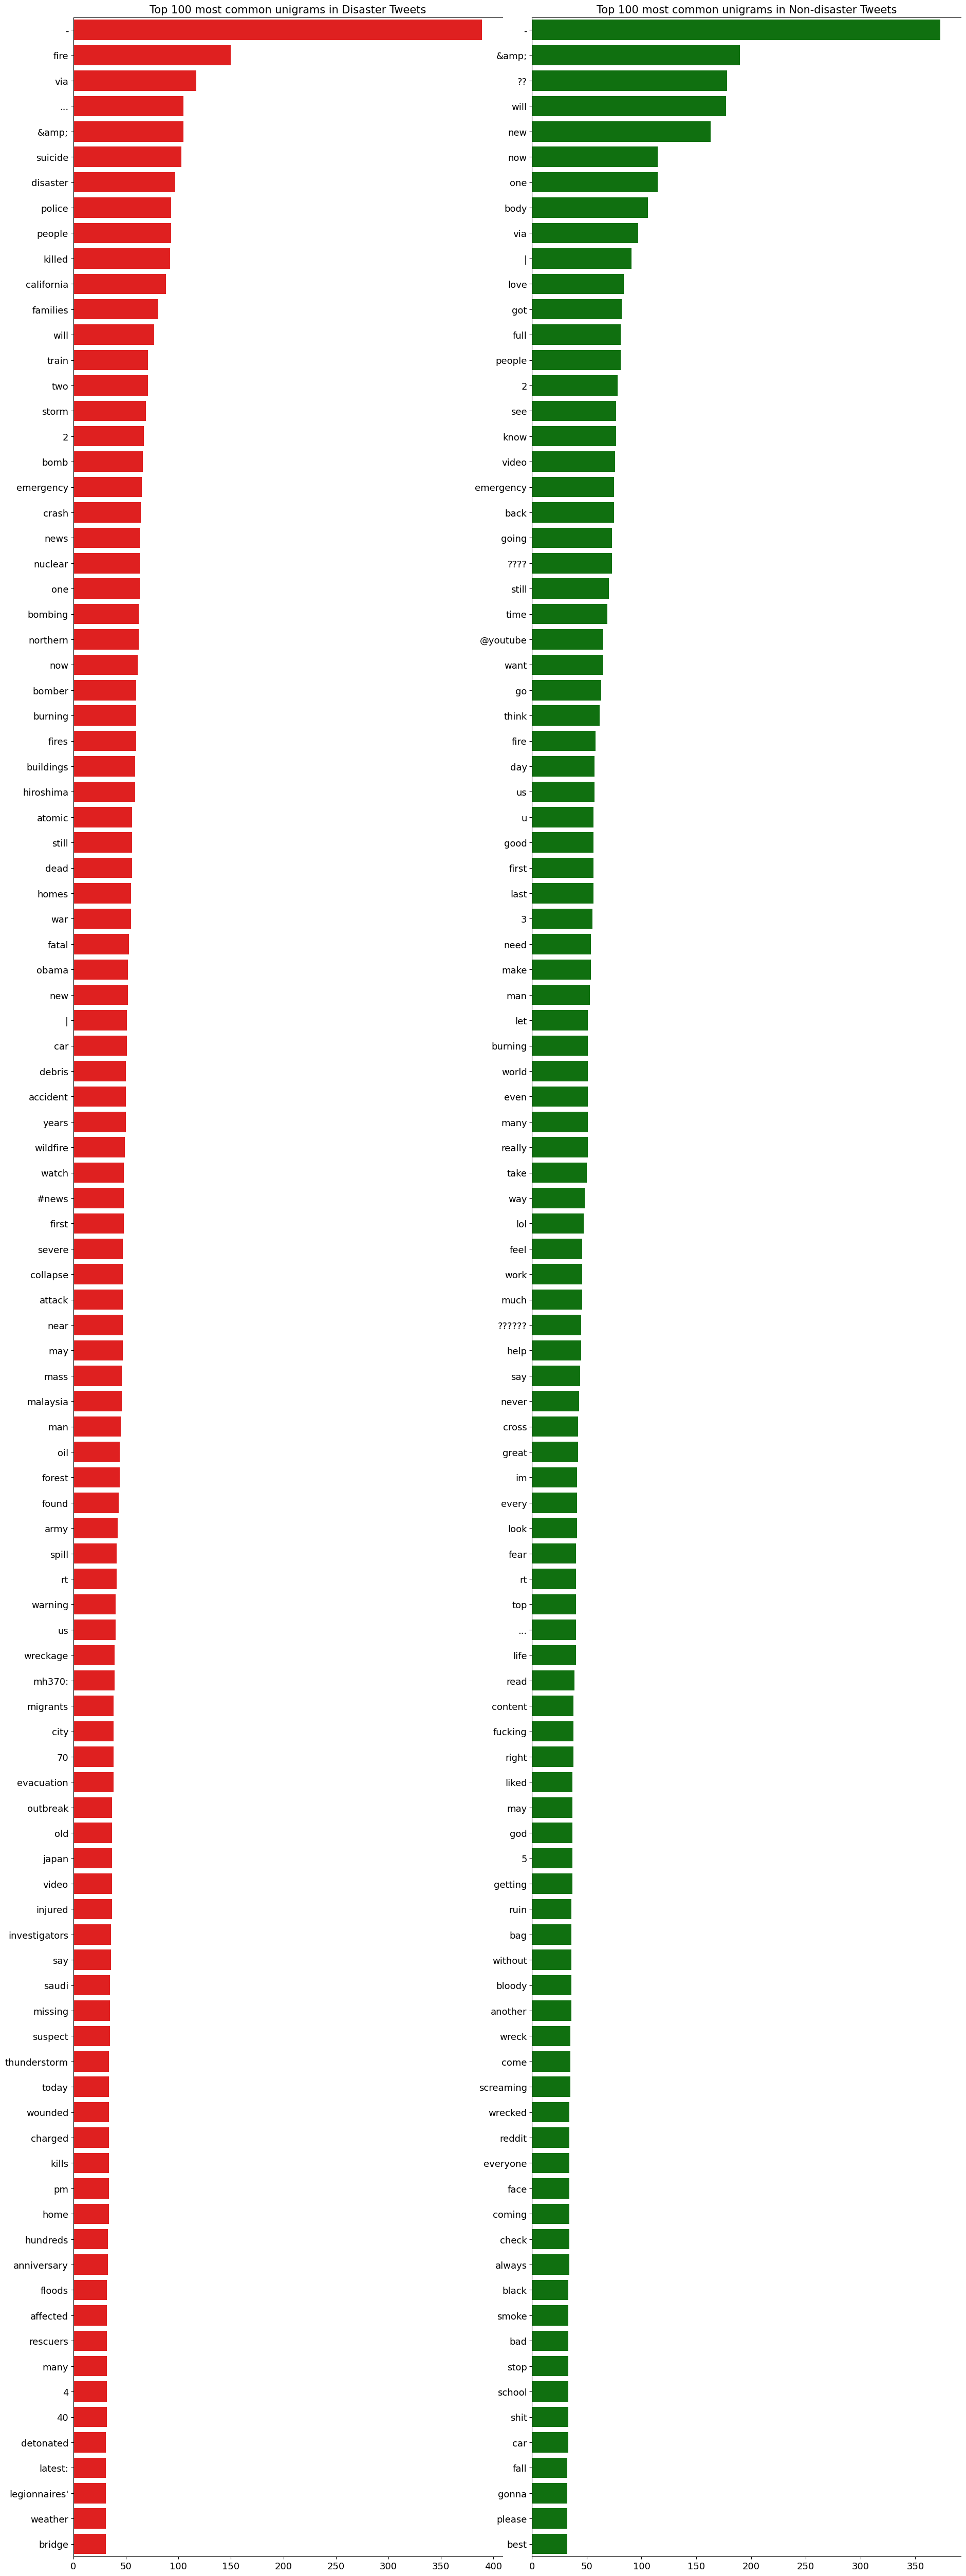

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_unigrams[0].values[:N], x=df_disaster_unigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_unigrams[0].values[:N], x=df_nondisaster_unigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common unigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common unigrams in Non-disaster Tweets', fontsize=15)

plt.show()

There are no common bigrams exist in both classes because the context is clearer.

Most common bigrams in disaster tweets are giving more information about the disasters than unigrams, but punctuations have to be stripped from words.

Most common bigrams in non-disaster tweets are mostly about reddit or youtube, and they contain lots of punctuations. Those punctuations have to be cleaned out of words as well.

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 137 (\x89) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


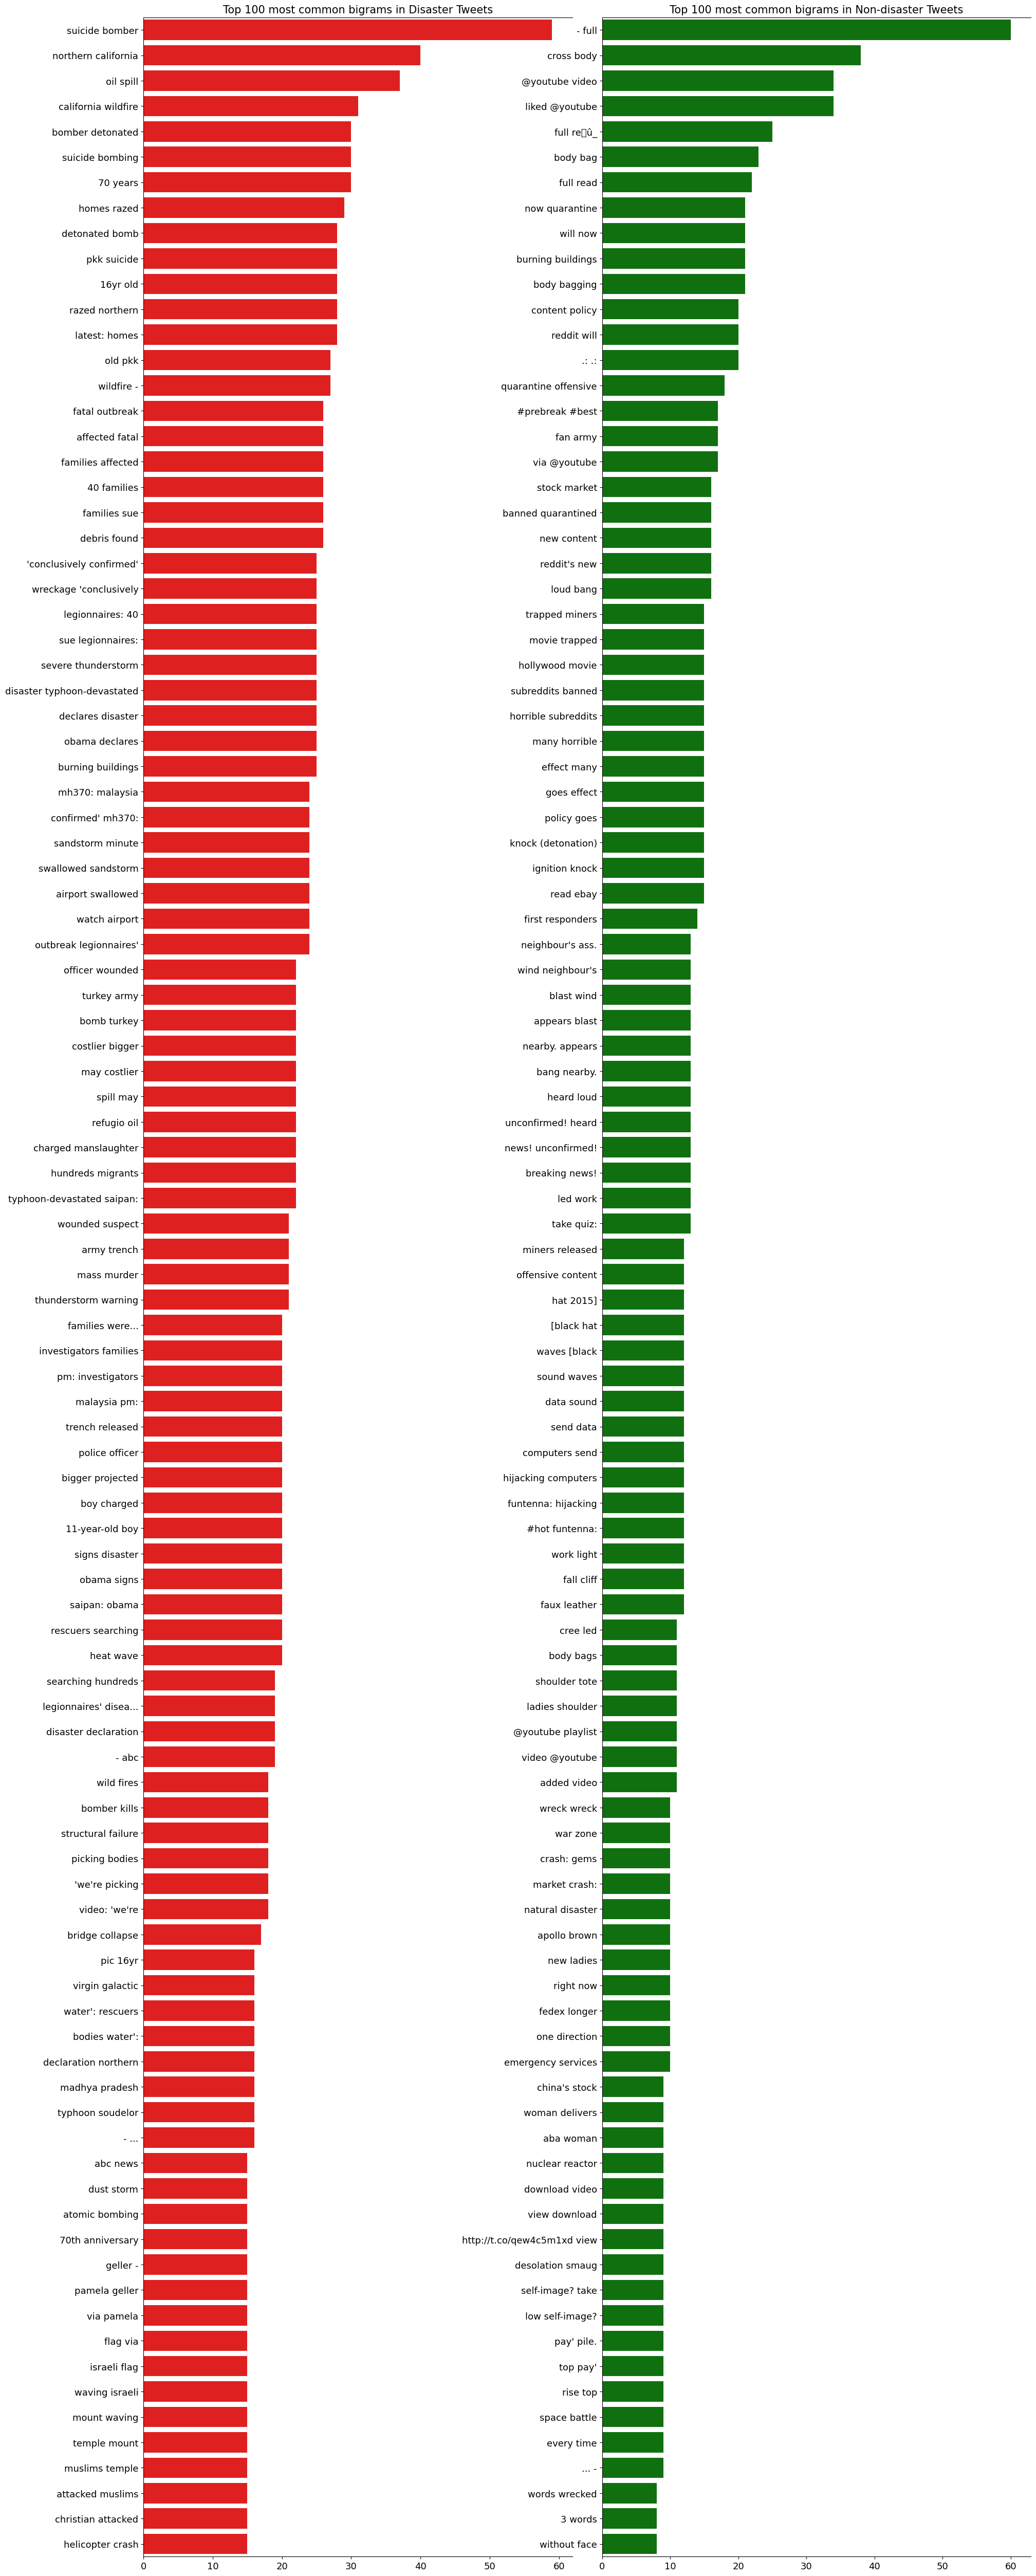

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_bigrams[0].values[:N], x=df_disaster_bigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_bigrams[0].values[:N], x=df_nondisaster_bigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common bigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common bigrams in Non-disaster Tweets', fontsize=15)

plt.show()

There are no common trigrams exist in both classes because the context is clearer.

Most common trigrams in disaster tweets are very similar to bigrams. They give lots of information about disasters, but they may not provide any additional information along with bigrams.

Most common trigrams in non-disaster tweets are also very similar to bigrams, and they contain even more punctuations.

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 137 (\x89) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


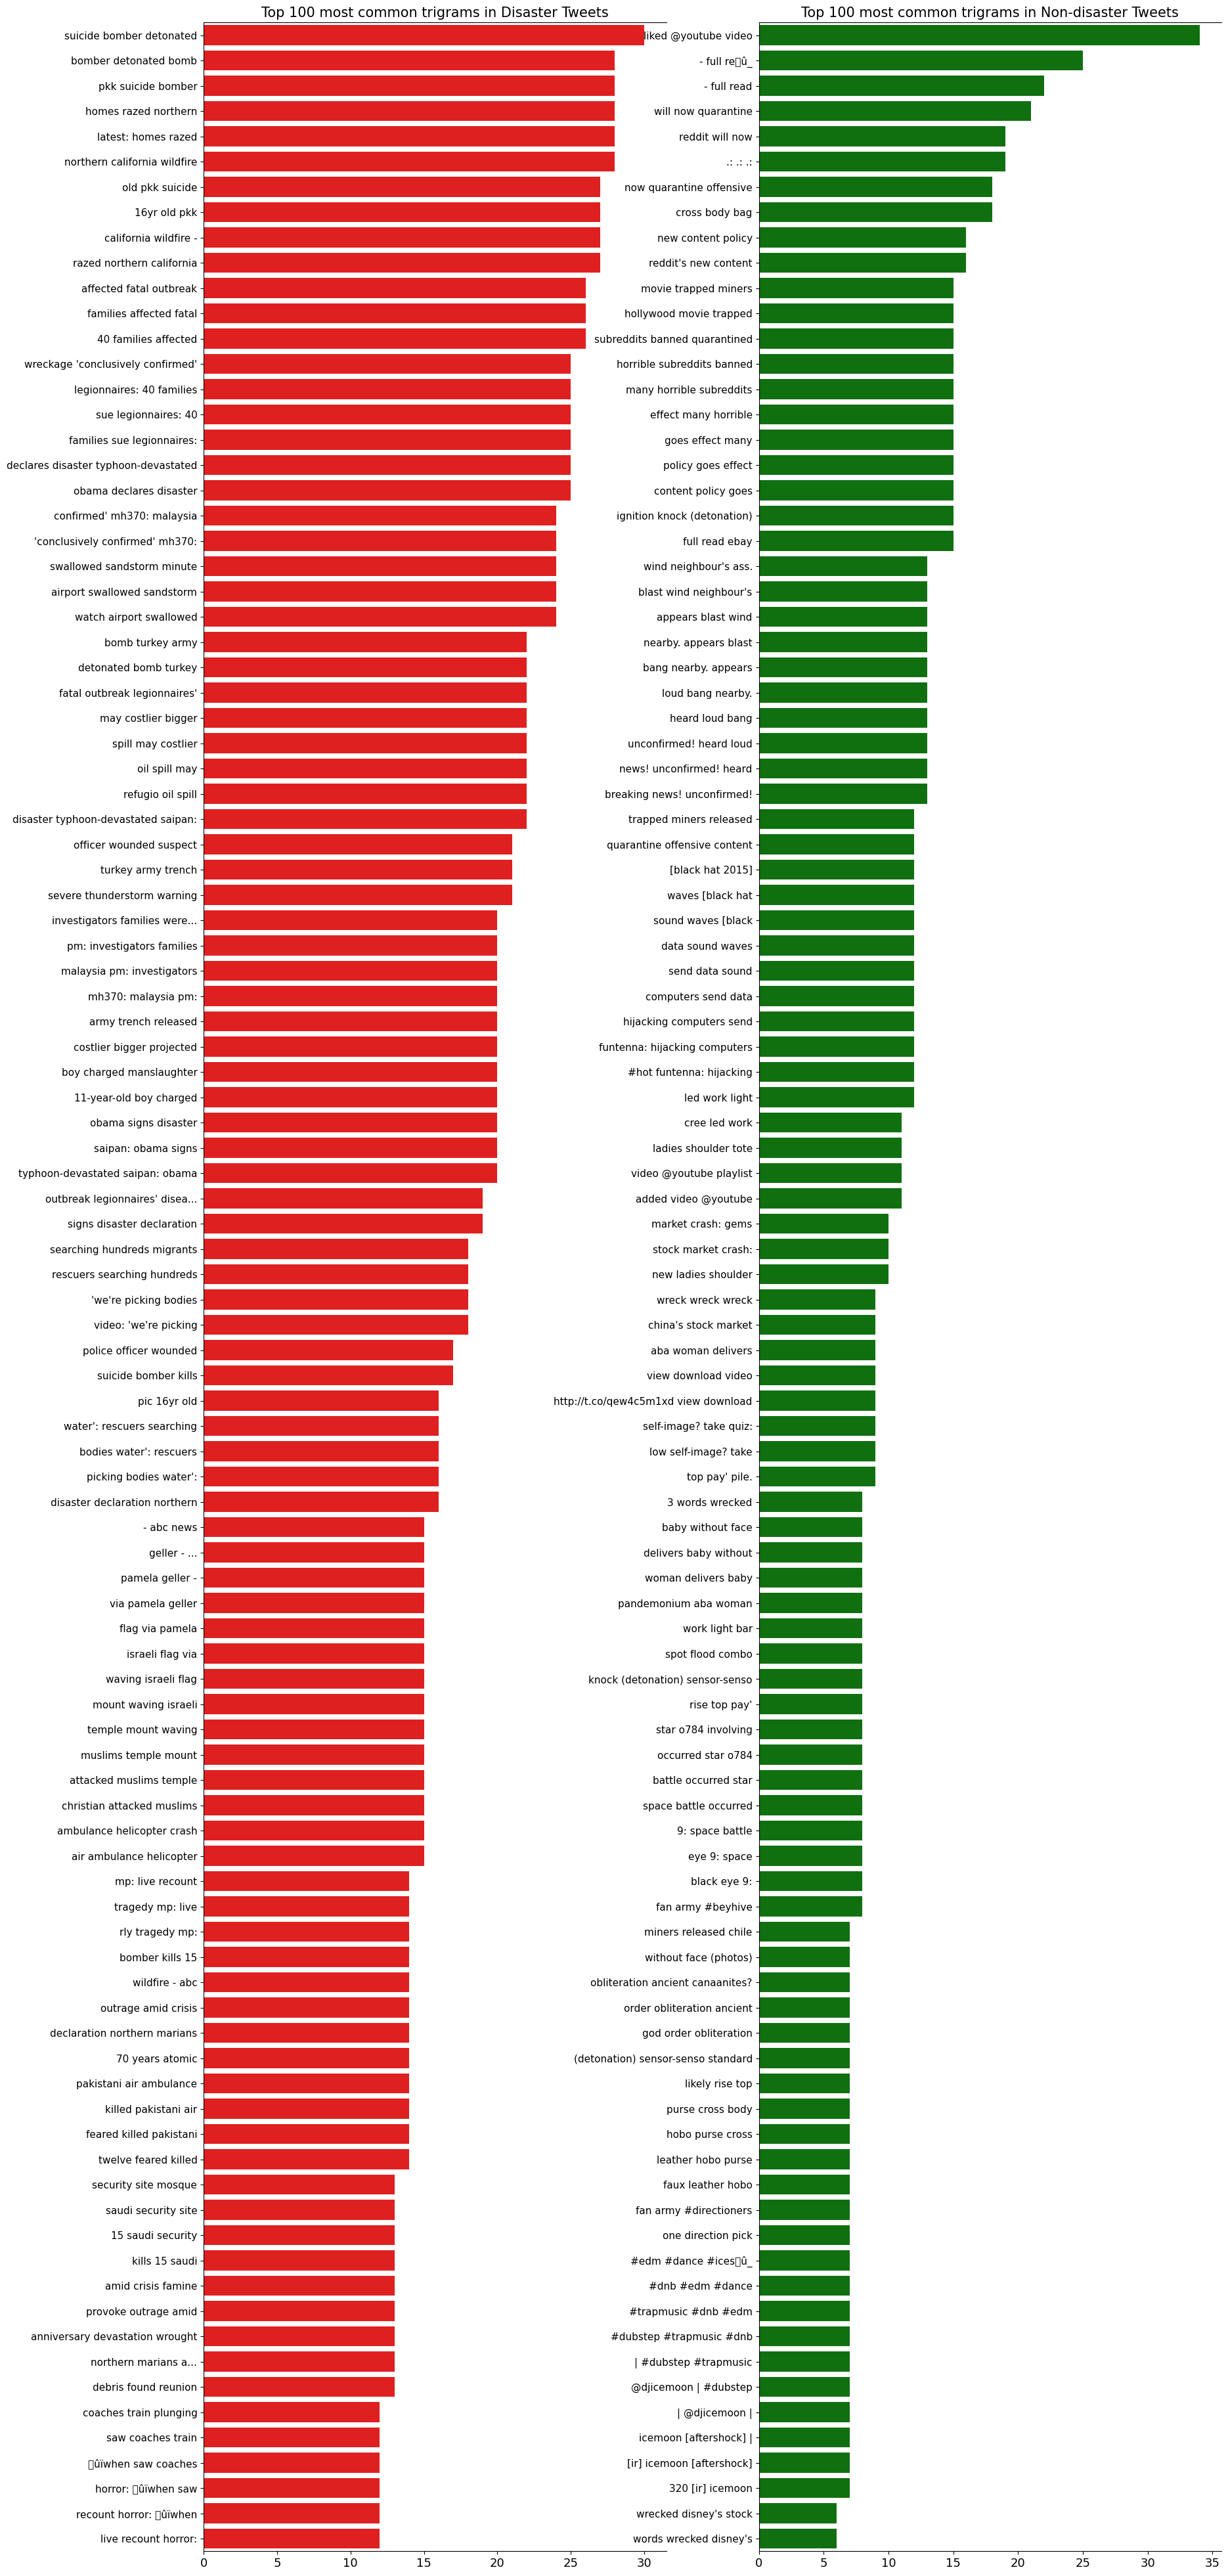

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 50), dpi=100)

sns.barplot(y=df_disaster_trigrams[0].values[:N], x=df_disaster_trigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_trigrams[0].values[:N], x=df_nondisaster_trigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=11)

axes[0].set_title(f'Top {N} most common trigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common trigrams in Non-disaster Tweets', fontsize=15)

plt.show()

##Model Building

In [ ]:
from spacy.lang.en import English
import spacy
from sklearn.model_selection import train_test_split
nlp = spacy.load("en_core_web_sm")

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
#cleaned and processed file is read
df_train = pd.read_csv('/content/distaster_tweets_cleaned.csv')
print(df_train.head(5))

   Unnamed: 0  id keyword location  \
0           0   1     NaN      NaN   
1           1   4     NaN      NaN   
2           2   5     NaN      NaN   
3           3   6     NaN      NaN   
4           4   7     NaN      NaN   

                                                text  target  \
0  Our Deeds are the Reason of this #earthquake M...       1   
1             Forest fire near La Ronge Sask. Canada       1   
2  All residents asked to 'shelter in place' are ...       1   
3  13,000 people receive #wildfires evacuation or...       1   
4  Just got sent this photo from Ruby #Alaska as ...       1   

                                               tweet  \
0   Our Deeds are the Reason of this #earthquake ...   
1             Forest fire near La Ronge Sask. Canada   
2   All residents asked to 'shelter in place' are...   
3   13,000 people receive #wildfires evacuation o...   
4   Just got sent this photo from Ruby #Alaska as...   

                                         tweet_lo

In [ ]:
df_train['new_text']=df_train['tweet_final'].apply(lambda x:nlp(x))
df_train.head()

Unnamed: 0  id keyword location  \
0           0   1     NaN      NaN   
1           1   4     NaN      NaN   
2           2   5     NaN      NaN   
3           3   6     NaN      NaN   
4           4   7     NaN      NaN   

                                                text  target  \
0  Our Deeds are the Reason of this #earthquake M...       1   
1             Forest fire near La Ronge Sask. Canada       1   
2  All residents asked to 'shelter in place' are ...       1   
3  13,000 people receive #wildfires evacuation or...       1   
4  Just got sent this photo from Ruby #Alaska as ...       1   

                                               tweet  \
0   Our Deeds are the Reason of this #earthquake ...   
1             Forest fire near La Ronge Sask. Canada   
2   All residents asked to 'shelter in place' are...   
3   13,000 people receive #wildfires evacuation o...   
4   Just got sent this photo from Ruby #Alaska as...   

                                         tweet_lower  \
0   our deeds are the reason of this #earthquake ...   
1             forest fire near la ronge sask. canada   
2   all residents asked to 'shelter in place' are...   
3   13,000 people receive #wildfires evacuation o...   
4   just got sent this photo from ruby #alaska as...   

                                        tweet_noHTML  \
0  our deeds are the reason of this #earthquake m...   
1             forest fire near la ronge sask. canada   
2  all residents asked to 'shelter in place' are ...   
3  13,000 people receive #wildfires evacuation or...   
4  just got sent this photo from ruby #alaska as ...   

                                tweet_noContractions  ...  \
0  our deeds are the reason of this #earthquake m...  ...   
1             forest fire near la ronge sask. canada  ...   
2  all residents asked to 'shelter in place' are ...  ...   
3  13,000 people receive #wildfires evacuation or...  ...   
4  just got sent this photo from ruby #alaska as ...  ...   

                                     tweet_noUnicode  \
0  our deeds are the reason of this #earthquake m...   
1             forest fire near la ronge sask. canada   
2  all residents asked to 'shelter in place' are ...   
3  13,000 people receive #wildfires evacuation or...   
4  just got sent this photo from ruby #alaska as ...   

                                      tweet_noPuncts  \
0  our deeds are the reason of this  earthquake m...   
1             forest fire near la ronge sask  canada   
2  all residents asked to  shelter in place  are ...   
3  13 000 people receive  wildfires evacuation or...   
4  just got sent this photo from ruby  alaska as ...   

                                      tweet_noDigits  \
0  our deeds are the reason of this  earthquake m...   
1             forest fire near la ronge sask  canada   
2  all residents asked to  shelter in place  are ...   
3    people receive  wildfires evacuation orders ...   
4  just got sent this photo from ruby  alaska as ...   

                                   tweet_noStopwords  \
0       deeds reason earthquake may allah forgive us   
1              forest fire near la ronge sask canada   
2  residents asked shelter place notified officer...   
3  people receive wildfires evacuation orders cal...   
4  got sent photo ruby alaska smoke wildfires pou...   

                                  tweet_noExtraspace  \
0       deeds reason earthquake may allah forgive us   
1              forest fire near la ronge sask canada   
2  residents asked shelter place notified officer...   
3  people receive wildfires evacuation orders cal...   
4  got sent photo ruby alaska smoke wildfires pou...   

                                    tweet_lemmatised  \
0         deed reason earthquake may allah forgive u   
1              forest fire near la ronge sask canada   
2  resident asked shelter place notified officer ...   
3  people receive wildfire evacuation order calif...   
4  got sent photo ruby alaska smoke wildfire p

In [ ]:
def transform(text):
    doc=nlp(text,disable=['parser','ner'])
    lemmas=[token.lemma_ for token in doc]
    a_lemmas=[lemma for lemma in lemmas if lemma.isalpha()]
    return ' '.join(a_lemmas)

df_train['new_text']=df_train['new_text'].apply(transform)
df_train['new_text']
X=df_train['new_text']
Y=df_train['target']

df_train.shape
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,random_state=4,test_size=0.2,stratify=Y)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer=TfidfVectorizer(stop_words='english')
X_train=vectorizer.fit_transform(X_train)
X_test=vectorizer.transform(X_test)

#Model Testing

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
from sklearn.naive_bayes import MultinomialNB

In [ ]:
models = []
models.append(('Logistic Regression', LogisticRegression()))
models.append(('Kernel SVM', SVC()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('Multinomial NB', MultinomialNB()))
models.append(('Random Forest', RandomForestClassifier()))
models.append(('Decision Tree Classifier', DecisionTreeClassifier()))
models
X_train.shape

(6090, 8109)

##KFold Cross Validation
The k-fold cross-validation method is widely used for calculating how well a machine learning model performs on a validation dataset.Once a k-value is determined, we can use it to assess various models on the dataset. We may then contrast the pattern of the scores to the scores of an analysis of the same model under the ideal test scenario to see whether or not they are strongly correlated.

Randomly shuffle the complete dataset.
The algorithm then divides the dataset into k groups, i.e., k folds of data
For every distinct group:
Use the dataset as a holdout dataset to validate the model.
The rest of the groups' datasets are used to train the model.
Fit a model onto the training dataset, then assess it on the holdout or validation dataset.
Keep the evaluation result but throw away the model generated.
Using the results of the model evaluation scores, summarise the model's performance

In [ ]:
from sklearn import model_selection
acc_score=[]
auc_score=[]
pre_results=[]
f1_results=[]
recall_results=[]
names=[]
result_col=pd.DataFrame(columns=['Algorithm','accuracy','ROC','Precision','f1_score','recall'])
result_col

i=0
for name,model in models:
    kfold=model_selection.KFold(n_splits=10)
    names.append(name)
    cv_acc_results = model_selection.cross_val_score(model, X_train, Y_train,cv=kfold,scoring="accuracy")
    cv_auc_results = model_selection.cross_val_score(model, X_train, Y_train,cv=kfold,scoring="roc_auc")
    cv_pre_results = model_selection.cross_val_score(model, X_train, Y_train,cv=kfold,scoring="precision")
    cv_f1_results = model_selection.cross_val_score(model, X_train, Y_train,cv=kfold,scoring="f1")
    cv_recall_results = model_selection.cross_val_score(model, X_train, Y_train,cv=kfold,scoring="recall")
    acc_score.append(cv_acc_results)
    auc_score.append(auc_score)
    pre_results.append(cv_pre_results)
    f1_results.append(cv_f1_results)

    result_col.loc[i]=[name,round(cv_acc_results.mean()*100,2),
                           round(cv_auc_results.mean()*100,2),
                           round(cv_pre_results.mean()*100,2),
                           round(cv_f1_results.mean()*100,2),
                       round(cv_recall_results.mean()*100,2)]
    i+=1

result_col.sort_values(by=['ROC'],ascending=False)

Algorithm  accuracy    ROC  Precision  f1_score  recall
0       Logistic Regression     79.29  86.03      80.74     73.77   67.98
3            Multinomial NB     80.26  85.87      81.44     75.26   70.03
1                Kernel SVM     79.79  85.70      83.18     73.76   66.34
4             Random Forest     78.77  84.55      81.43     72.41   65.37
2                       KNN     75.24  79.78      80.44     66.03   56.12
5  Decision Tree Classifier     74.07  73.56      70.26     69.97   69.79

In [ ]:
models_tuned = []

models_tuned.append(('Logistic Regression', LogisticRegression(solver='liblinear',C = 10, max_iter=500, random_state = 0)))
models_tuned.append(('SVC', SVC(C=1, kernel = 'linear', gamma=1, random_state = 0)))
models_tuned.append(('Kernel SVM', SVC(C=1, kernel = 'rbf', gamma=1, random_state = 0)))
models_tuned.append(('KNN', KNeighborsClassifier(n_neighbors = 5, metric = 'euclidean', p = 2,algorithm='brute')))
models_tuned.append(('Multinomial NB', MultinomialNB()))
models_tuned.append(('Decision Tree Classifier', DecisionTreeClassifier(criterion = 'gini', max_leaf_nodes=19, random_state = 0)))
models_tuned.append(('Random Forest', RandomForestClassifier(max_leaf_nodes = 24,max_features = 25,
                                                           n_estimators = 50,criterion = 'entropy', random_state = 0)))

In [ ]:
acc_results_opt =[]
auc_results_opt =[]
pre_results_opt =[]
f1_results_opt =[]
recall_results_opt=[]
names_opt = []

result_col_opt = ["Algorithm", "ROC AUC", "Accuracy", 'Precision', 'F1 Scores','recall']
model_results_opt = pd.DataFrame(columns = result_col_opt)

C = 1 # algorithm name
kernel = 'rbf'# kernel type
gamma =  1 # kernel parameter
# Train and test model
good_modelsvm = svm.SVC(C=C, kernel=kernel,
                                  gamma=gamma) # create model
print(good_modelsvm) # display model parameters
good_modelsvm.fit(X_train,Y_train) # train model

i=0
# K- fold cross validation

for name, model in models_tuned:
    names_opt.append(name)
    kfold = model_selection.KFold(n_splits=10)

    cv_acc_results_opt = model_selection.cross_val_score(model, X_test, Y_test,
                    cv = kfold, scoring="accuracy")
    cv_auc_results_opt = model_selection.cross_val_score(model, X_test, Y_test,
                    cv = kfold, scoring="roc_auc")
    cv_pre_results_opt = model_selection.cross_val_score(model, X_test, Y_test,
                    cv = kfold, scoring="precision")
    cv_f1_results_opt = model_selection.cross_val_score(model, X_test, Y_test,
                    cv = kfold, scoring="f1")
    cv_recall_results_opt = model_selection.cross_val_score(model, X_test, Y_test,
                    cv = kfold, scoring="recall")
    acc_results_opt.append(cv_acc_results_opt)
    auc_results_opt.append(cv_auc_results_opt)
    pre_results_opt.append(cv_pre_results_opt)
    f1_results_opt.append(cv_f1_results_opt)
    model_results_opt.loc[i] = [name,
                           round(cv_auc_results_opt.mean()*100,2),
                           round(cv_acc_results_opt.mean()*100,2),
                           round(cv_pre_results_opt.mean()*100,2),
                           round(cv_f1_results_opt.mean()*100,2),
                           round(cv_recall_results_opt.mean()*100,2)]
    i+=1
model_results_opt.sort_values(by = ['ROC AUC'], ascending=False)


SVC(C=1, gamma=1)


Algorithm  ROC AUC  Accuracy  Precision  F1 Scores  recall
4            Multinomial NB    80.67     74.79      79.90      65.49   55.75
0       Logistic Regression    80.04     73.80      73.15      67.21   62.65
1                       SVC    79.96     74.72      74.60      68.13   62.98
2                Kernel SVM    79.81     73.54      77.80      63.46   53.81
6             Random Forest    76.74     62.97      98.75      24.35   14.12
3                       KNN    71.66     69.86      70.86      58.94   50.83
5  Decision Tree Classifier    60.43     64.48      73.20      39.88   27.73

In [ ]:
def text_cleaner(text):
    text = text.lower() # convert to lowercase
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text) # remove punctuation and special characters
    text = re.sub(r'\s+', ' ', text) # remove extra whitespace
    text = re.sub(r'https?://\S+', '', text) # remove URLs
    text = re.sub(r"#", "", text)
    return text

In [ ]:
df_test['clean_text']=df_test['text'].apply(text_cleaner)
df_test['clean_text'] = df_test['clean_text'].apply(lambda x: nlp(x))

In [ ]:
df_test['clean_text_str'] = df_test['clean_text'].apply(lambda doc: ' '.join([token.lower_ for token in doc]))
eval = vectorizer.transform(df_test['clean_text_str']).toarray()


C = 1 # algorithm name
kernel = 'rbf'# kernel type
gamma =  1 # kernel parameter

# Train and test model
good_modelsvm = svm.SVC(C=C, kernel=kernel,
                                  gamma=gamma) # create model
print(good_modelsvm) # display model parameters
good_modelsvm.fit(X_train,Y_train) # train model
final_pred = good_modelsvm.predict(eval)
final_pred.shape
submission2 = df_test[['id']].reset_index(drop=True)
submission2['target'] = final_pred.astype('int64')
submission2.to_csv('submission.csv', index=False)

SVC(C=1, gamma=1)


In [ ]:
df_train.to_csv("new.csv")

In [ ]:
# Most basic stuff for EDA.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Core packages for text processing.

import string
import re

# Libraries for text preprocessing.

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

# Loading some sklearn packaces for modelling.

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import f1_score, accuracy_score

# Some packages for word clouds and NER.

from wordcloud import WordCloud, STOPWORDS
from collections import Counter, defaultdict
from PIL import Image
import spacy
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.5/en_core_web_sm-2.2.5.tar.gz
import en_core_web_sm

# Core packages for general use throughout the notebook.

import random
import warnings
import time
import datetime

# For customizing our plots.

from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

# Loading pytorch packages.

import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler

# Setting some options for general use.

stop = set(stopwords.words('english'))
plt.style.use('fivethirtyeight')
sns.set(font_scale=1.5)
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250
warnings.filterwarnings('ignore')


#Setting seeds for consistent results.
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
     |████████████████████████████████| 12.0 MB 370 kB/s 
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.2.5-py3-none-any.whl size=12011738 sha256=9e837d289feb72bf7e9ce2cdc0c537994970d73d940d1b8a937ff21b686c2a8e
  Stored in directory: /root/.cache/pip/wheels/51/19/da/a3885266a3c241aff0ad2eb674ae058fd34a4870fef1c0a5a0
Successfully built en-core-web-sm


wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


<a id="Loading_the_Data"></a>
## Loading the Data

#### Let's load our train and test data, I added "v"'s at the end of our variables for visualization because some of the pre-processing are not needed for the modelling but we can use them for our EDA part. Anyways let's look at our given data:

#### Well... We have keywords, locations, text and our target labels. We gonna use the text feature for our modelling here.

### [Back To Table of Contents](#top_section)

In [ ]:
# Loading the train and test data for visualization & exploration.

trainv = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
testv = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

In [ ]:
# Taking general look at the both datasets.

display(trainv.sample(5))
display(testv.sample(5))

id      keyword               location  \
2644  3796  destruction                    NaN   
2227  3185       deluge                    NaN   
5448  7769       police                     UK   
132    191   aftershock                    NaN   
6845  9810       trauma  Montgomery County, MD   

                                                   text  target  
2644  So you have a new weapon that can cause un-ima...       1  
2227  The f$&amp;@ing things I do for #GISHWHES Just...       0  
5448  DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...       1  
132   Aftershock back to school kick off was great. ...       0  
6845  in response to trauma Children of Addicts deve...       0

id     keyword                     location  \
142    449  armageddon              1996???????????   
2672  8915   snowstorm                  Los Angeles   
2605  8682    sinkhole           New York, New York   
2515  8381        ruin                   Monroe, OH   
958   3187      deluge  West Powelton, Philadelphia   

                                                   text  
142   UNIVERSAL ORDER OF ARMAGEDDON http://t.co/3tY4mGm  
2672  @BigBang_CBS ...wow...ok...um...that was like ...  
2605  The sinkhole that ate Brooklyn http://t.co/28r...  
2515  Don't ruin a good today by thinking about a ba...  
958   I'm havin previous life flashbacks of when i l...

In [ ]:
# Checking observation and feature numbers for train and test data.

print(trainv.shape)
print(testv.shape)

(7613, 5)
(3263, 4)


<a id="Cleaning_Text"></a>
## Cleaning Text

#### Alright! Before we visualize our text data I wanted to make it look better with some general helper functions to clear out things like: urls, emojis, html tags, punctuations... We'll add all of them in one column called 'text_clean' then move from there for next steps. When we have cleaner text we can apply our tokenizer to split each word into a token. I'll apply this and next steps to individual columns to show each step of our progress. Next we transforming all words to lowercase then we remove stopwords (they don't mean much in sentence alone) so we use NLTK stopwords for it.

#### After removing these words we gonna lemmatize them but for that we need to add some extra steps to do it properly: We gonna apply part of speech tags to our text (like verb, noun etc.) then we convert them to wordnet format and finally we can apply lemmatizer and save it to 'lemmatized' column. And one last thing we convert these tokenized lists back to str version for future uses.

#### So basically what we did are:
- Removed urls, emojis, html tags and punctuations,
- Tokenized the tweet base texts,
- Lower cased clean text,
- Removed stopwords,
- Applied part of speech tags,
- Converted part of speeches to wordnet format,
- Applying word lemmatizer,
- Converted tokenized text to string again.


Others BERT can Manage , no need a lot as we saw in ML

In [ ]:
# Some basic helper functions to clean text by removing urls, emojis, html tags and punctuations.

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

# Applying helper functions

trainv['text_clean'] = trainv['text'].apply(lambda x: remove_URL(x))
trainv['text_clean'] = trainv['text_clean'].apply(lambda x: remove_emoji(x))
trainv['text_clean'] = trainv['text_clean'].apply(lambda x: remove_html(x))
trainv['text_clean'] = trainv['text_clean'].apply(lambda x: remove_punct(x))

In [ ]:
# Tokenizing the tweet base texts.

trainv['tokenized'] = trainv['text_clean'].apply(word_tokenize)

trainv.head()

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target                                         text_clean  \
0       1  Our Deeds are the Reason of this earthquake Ma...   
1       1              Forest fire near La Ronge Sask Canada   
2       1  All residents asked to shelter in place are be...   
3       1  13000 people receive wildfires evacuation orde...   
4       1  Just got sent this photo from Ruby Alaska as s...   

                                           tokenized  
0  [Our, Deeds, are, the, Reason, of, this, earth...  
1      [Forest, fire, near, La, Ronge, Sask, Canada]  
2  [All, residents, asked, to, shelter, in, place...  
3  [13000, people, receive, wildfires, evacuation...  
4  [Just, got, sent, this, photo, from, Ruby, Ala...

In [ ]:
# Lower casing clean text.

trainv['lower'] = trainv['tokenized'].apply(
    lambda x: [word.lower() for word in x])

trainv.head()

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target                                         text_clean  \
0       1  Our Deeds are the Reason of this earthquake Ma...   
1       1              Forest fire near La Ronge Sask Canada   
2       1  All residents asked to shelter in place are be...   
3       1  13000 people receive wildfires evacuation orde...   
4       1  Just got sent this photo from Ruby Alaska as s...   

                                           tokenized  \
0  [Our, Deeds, are, the, Reason, of, this, earth...   
1      [Forest, fire, near, La, Ronge, Sask, Canada]   
2  [All, residents, asked, to, shelter, in, place...   
3  [13000, people, receive, wildfires, evacuation...   
4  [Just, got, sent, this, photo, from, Ruby, Ala...   

                                               lower  
0  [our, deeds, are, the, reason, of, this, earth...  
1      [forest, fire, near, la, ronge, sask, canada]  
2  [all, residents, asked, to, shelter, in, place...  
3  [13000, people, receive, wildfires, evacuation...  
4  [just, got, sent, this, photo, from, ruby, ala...

In [ ]:
# Removing stopwords.

trainv['stopwords_removed'] = trainv['lower'].apply(
    lambda x: [word for word in x if word not in stop])

trainv.head()

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target                                         text_clean  \
0       1  Our Deeds are the Reason of this earthquake Ma...   
1       1              Forest fire near La Ronge Sask Canada   
2       1  All residents asked to shelter in place are be...   
3       1  13000 people receive wildfires evacuation orde...   
4       1  Just got sent this photo from Ruby Alaska as s...   

                                           tokenized  \
0  [Our, Deeds, are, the, Reason, of, this, earth...   
1      [Forest, fire, near, La, Ronge, Sask, Canada]   
2  [All, residents, asked, to, shelter, in, place...   
3  [13000, people, receive, wildfires, evacuation...   
4  [Just, got, sent, this, photo, from, Ruby, Ala...   

                                               lower  \
0  [our, deeds, are, the, reason, of, this, earth...   
1      [forest, fire, near, la, ronge, sask, canada]   
2  [all, residents, asked, to, shelter, in, place...   
3  [13000, people, receive, wildfires, evacuation...   
4  [just, got, sent, this, photo, from, ruby, ala...   

                                   stopwords_removed  
0  [deeds, reason, earthquake, may, allah, forgiv...  
1      [forest, fire, near, la, ronge, sask, canada]  
2  [residents, asked, shelter, place, notified, o...  
3  [13000, people, receive, wildfires, evacuation...  
4  [got, sent, photo, ruby, alaska, smoke, wildfi...

In [ ]:
# Applying part of speech tags.

trainv['pos_tags'] = trainv['stopwords_removed'].apply(nltk.tag.pos_tag)

trainv.head()

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target                                         text_clean  \
0       1  Our Deeds are the Reason of this earthquake Ma...   
1       1              Forest fire near La Ronge Sask Canada   
2       1  All residents asked to shelter in place are be...   
3       1  13000 people receive wildfires evacuation orde...   
4       1  Just got sent this photo from Ruby Alaska as s...   

                                           tokenized  \
0  [Our, Deeds, are, the, Reason, of, this, earth...   
1      [Forest, fire, near, La, Ronge, Sask, Canada]   
2  [All, residents, asked, to, shelter, in, place...   
3  [13000, people, receive, wildfires, evacuation...   
4  [Just, got, sent, this, photo, from, Ruby, Ala...   

                                               lower  \
0  [our, deeds, are, the, reason, of, this, earth...   
1      [forest, fire, near, la, ronge, sask, canada]   
2  [all, residents, asked, to, shelter, in, place...   
3  [13000, people, receive, wildfires, evacuation...   
4  [just, got, sent, this, photo, from, ruby, ala...   

                                   stopwords_removed  \
0  [deeds, reason, earthquake, may, allah, forgiv...   
1      [forest, fire, near, la, ronge, sask, canada]   
2  [residents, asked, shelter, place, notified, o...   
3  [13000, people, receive, wildfires, evacuation...   
4  [got, sent, photo, ruby, alaska, smoke, wildfi...   

                                            pos_tags  
0  [(deeds, NNS), (reason, NN), (earthquake, NN),...  
1  [(forest, JJS), (fire, NN), (near, IN), (la, J...  
2  [(residents, NNS), (asked, VBD), (shelter, JJ)...  
3  [(13000, CD), (people, NNS), (receive, JJ), (w...  
4  [(got, VBD), (sent, JJ), (photo, NN), (ruby, N...

In [ ]:
# Converting part of speeches to wordnet format.

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


trainv['wordnet_pos'] = trainv['pos_tags'].apply(
    lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

trainv.head()

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target                                         text_clean  \
0       1  Our Deeds are the Reason of this earthquake Ma...   
1       1              Forest fire near La Ronge Sask Canada   
2       1  All residents asked to shelter in place are be...   
3       1  13000 people receive wildfires evacuation orde...   
4       1  Just got sent this photo from Ruby Alaska as s...   

                                           tokenized  \
0  [Our, Deeds, are, the, Reason, of, this, earth...   
1      [Forest, fire, near, La, Ronge, Sask, Canada]   
2  [All, residents, asked, to, shelter, in, place...   
3  [13000, people, receive, wildfires, evacuation...   
4  [Just, got, sent, this, photo, from, Ruby, Ala...   

                                               lower  \
0  [our, deeds, are, the, reason, of, this, earth...   
1      [forest, fire, near, la, ronge, sask, canada]   
2  [all, residents, asked, to, shelter, in, place...   
3  [13000, people, receive, wildfires, evacuation...   
4  [just, got, sent, this, photo, from, ruby, ala...   

                                   stopwords_removed  \
0  [deeds, reason, earthquake, may, allah, forgiv...   
1      [forest, fire, near, la, ronge, sask, canada]   
2  [residents, asked, shelter, place, notified, o...   
3  [13000, people, receive, wildfires, evacuation...   
4  [got, sent, photo, ruby, alaska, smoke, wildfi...   

                                            pos_tags  \
0  [(deeds, NNS), (reason, NN), (earthquake, NN),...   
1  [(forest, JJS), (fire, NN), (near, IN), (la, J...   
2  [(residents, NNS), (asked, VBD), (shelter, JJ)...   
3  [(13000, CD), (people, NNS), (receive, JJ), (w...   
4  [(got, VBD), (sent, JJ), (photo, NN), (ruby, N...   

                                         wordnet_pos  
0  [(deeds, n), (reason, n), (earthquake, n), (ma...  
1  [(forest, a), (fire, n), (near, n), (la, a), (...  
2  [(residents, n), (asked, v), (shelter, a), (pl...  
3  [(13000, n), (people, n), (receive, a), (wildf...  
4  [(got, v), (sent, a), (photo, n), (ruby, n), (...

In [ ]:
# Applying word lemmatizer.

wnl = WordNetLemmatizer()

trainv['lemmatized'] = trainv['wordnet_pos'].apply(
    lambda x: [wnl.lemmatize(word, tag) for word, tag in x])

trainv['lemmatized'] = trainv['lemmatized'].apply(
    lambda x: [word for word in x if word not in stop])

trainv['lemma_str'] = [' '.join(map(str, l)) for l in trainv['lemmatized']]

trainv.head()

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target                                         text_clean  \
0       1  Our Deeds are the Reason of this earthquake Ma...   
1       1              Forest fire near La Ronge Sask Canada   
2       1  All residents asked to shelter in place are be...   
3       1  13000 people receive wildfires evacuation orde...   
4       1  Just got sent this photo from Ruby Alaska as s...   

                                           tokenized  \
0  [Our, Deeds, are, the, Reason, of, this, earth...   
1      [Forest, fire, near, La, Ronge, Sask, Canada]   
2  [All, residents, asked, to, shelter, in, place...   
3  [13000, people, receive, wildfires, evacuation...   
4  [Just, got, sent, this, photo, from, Ruby, Ala...   

                                               lower  \
0  [our, deeds, are, the, reason, of, this, earth...   
1      [forest, fire, near, la, ronge, sask, canada]   
2  [all, residents, asked, to, shelter, in, place...   
3  [13000, people, receive, wildfires, evacuation...   
4  [just, got, sent, this, photo, from, ruby, ala...   

                                   stopwords_removed  \
0  [deeds, reason, earthquake, may, allah, forgiv...   
1      [forest, fire, near, la, ronge, sask, canada]   
2  [residents, asked, shelter, place, notified, o...   
3  [13000, people, receive, wildfires, evacuation...   
4  [got, sent, photo, ruby, alaska, smoke, wildfi...   

                                            pos_tags  \
0  [(deeds, NNS), (reason, NN), (earthquake, NN),...   
1  [(forest, JJS), (fire, NN), (near, IN), (la, J...   
2  [(residents, NNS), (asked, VBD), (shelter, JJ)...   
3  [(13000, CD), (people, NNS), (receive, JJ), (w...   
4  [(got, VBD), (sent, JJ), (photo, NN), (ruby, N...   

                                         wordnet_pos  \
0  [(deeds, n), (reason, n), (earthquake, n), (ma...   
1  [(forest, a), (fire, n), (near, n), (la, a), (...   
2  [(residents, n), (asked, v), (shelter, a), (pl...   
3  [(13000, n), (people, n), (receive, a), (wildf...   
4  [(got, v), (sent, a), (photo, n), (ruby, n), (...   

                                          lemmatized  \
0  [deed, reason, earthquake, may, allah, forgive...   
1      [forest, fire, near, la, ronge, sask, canada]   
2  [resident, ask, shelter, place, notify, office...   
3  [13000, people, receive, wildfire, evacuation,...   
4  [get, sent, photo, ruby, alaska, smoke, wildfi...   

                                           lemma_str  
0         deed reason earthquake may allah forgive u  
1              forest fire near la ronge sask canada  
2  resident ask shelter place notify officer evac...  
3  13000 people receive wildfire evacuation order...  
4  get sent photo ruby alaska smoke wildfires pou...

<a id="Visualizing_the_Data"></a>
# Visualizing the Data

We can start visualizing the data to see if we can find some visible relations between tweet classes.



<a id="Target_Distribution"></a>
## Target Distribution

#### When we check our target variables and look at how they disturbuted we can say it not bad. There is no huge difference between classes we can say it's good sign for modelling.



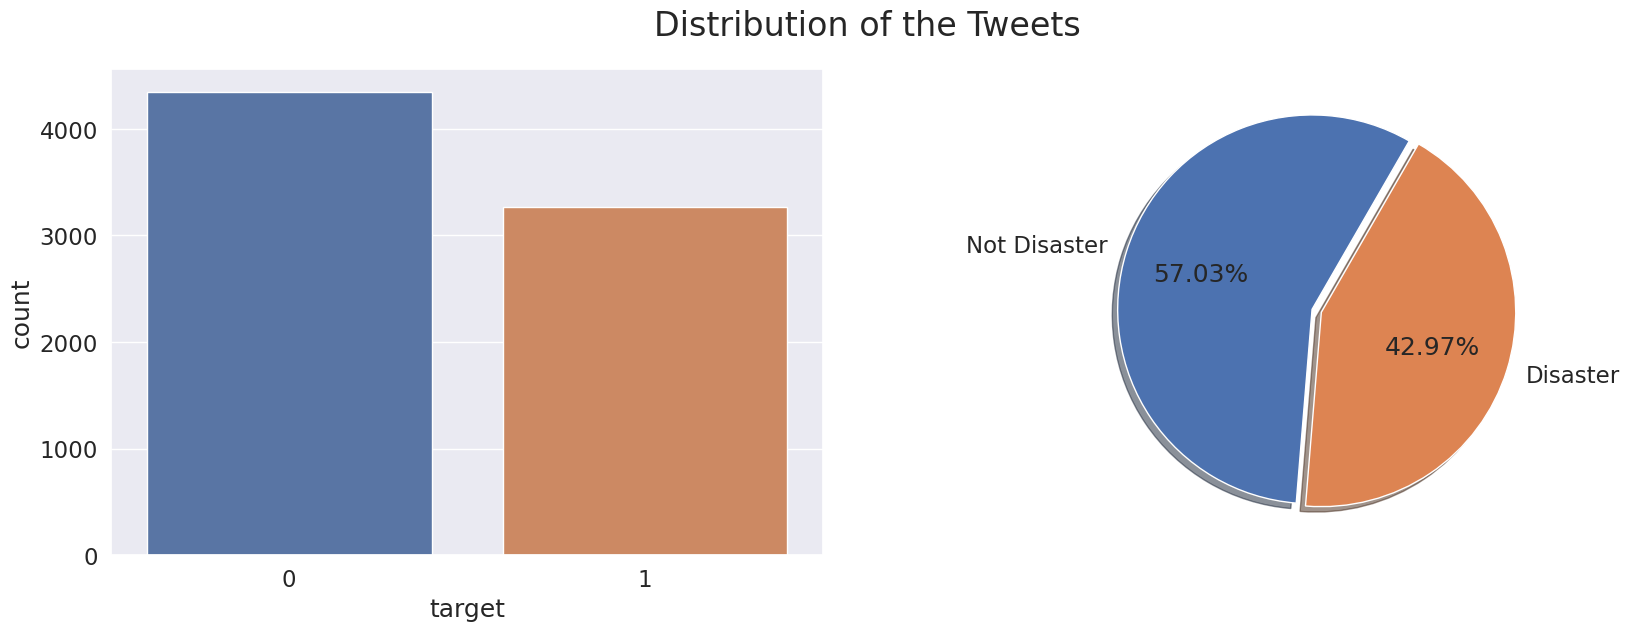

In [ ]:
# Displaying target distribution.

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), dpi=100)
sns.countplot(trainv['target'], ax=axes[0])
axes[1].pie(trainv['target'].value_counts(),
            labels=['Not Disaster', 'Disaster'],
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0),
            startangle=60)
fig.suptitle('Distribution of the Tweets', fontsize=24)
plt.show()

<a id="Tweet_Lengths"></a>
## Tweet Lengths

#### Let's start with the number of characters per tweet and compare if it's disaster related or not. It seems disaster tweets are longer than non disaster tweets in general. We can assume longer tweets are more likely for disasters but this is only an assumption and might be not true...



In [ ]:
# Creating a new feature for the visualization.

trainv['Character Count'] = trainv['text_clean'].apply(lambda x: len(str(x)))


def plot_dist3(df, feature, title):
    # Creating a customized chart. and giving in figsize and everything.
    fig = plt.figure(constrained_layout=True, figsize=(18, 8))
    # Creating a grid of 3 cols and 3 rows.
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

    # Customizing the histogram grid.
    ax1 = fig.add_subplot(grid[0, :2])
    # Set the title.
    ax1.set_title('Histogram')
    # plot the histogram.
    sns.distplot(df.loc[:, feature],
                 hist=True,
                 kde=True,
                 ax=ax1,
                 color='#e74c3c')
    ax1.set(ylabel='Frequency')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=20))

    # Customizing the ecdf_plot.
    ax2 = fig.add_subplot(grid[1, :2])
    # Set the title.
    ax2.set_title('Empirical CDF')
    # Plotting the ecdf_Plot.
    sns.distplot(df.loc[:, feature],
                 ax=ax2,
                 kde_kws={'cumulative': True},
                 hist_kws={'cumulative': True},
                 color='#e74c3c')
    ax2.xaxis.set_major_locator(MaxNLocator(nbins=20))
    ax2.set(ylabel='Cumulative Probability')

    # Customizing the Box Plot.
    ax3 = fig.add_subplot(grid[:, 2])
    # Set title.
    ax3.set_title('Box Plot')
    # Plotting the box plot.
    sns.boxplot(x=feature, data=df, orient='v', ax=ax3, color='#e74c3c')
    ax3.yaxis.set_major_locator(MaxNLocator(nbins=25))

    plt.suptitle(f'{title}', fontsize=24)

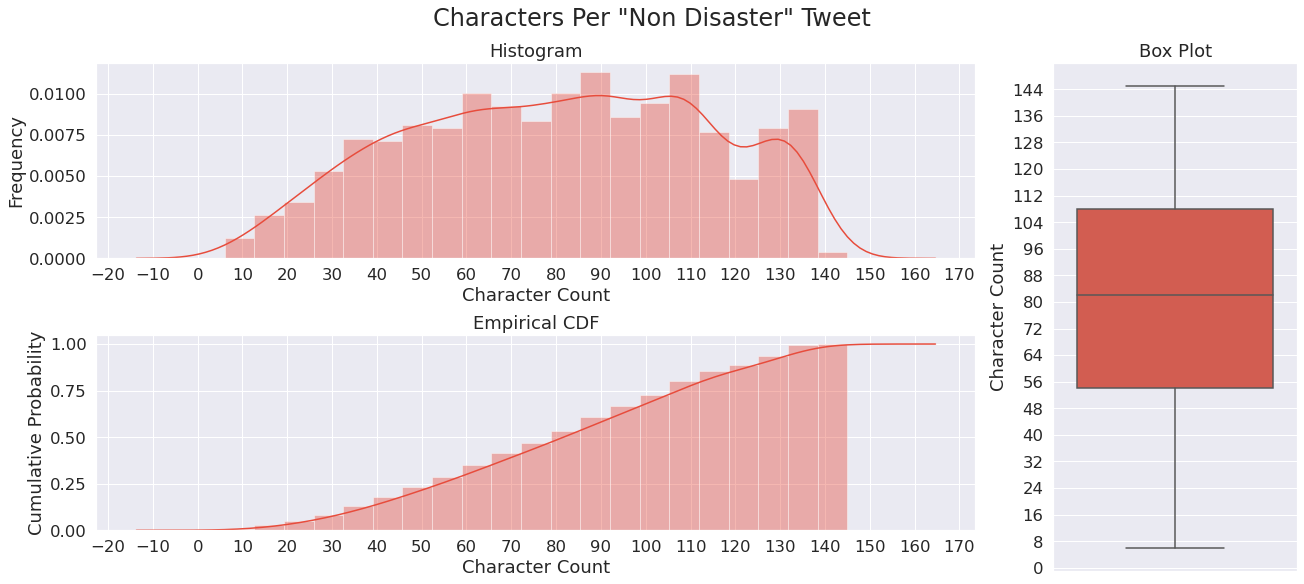

In [ ]:
plot_dist3(trainv[trainv['target'] == 0], 'Character Count',
           'Characters Per "Non Disaster" Tweet')

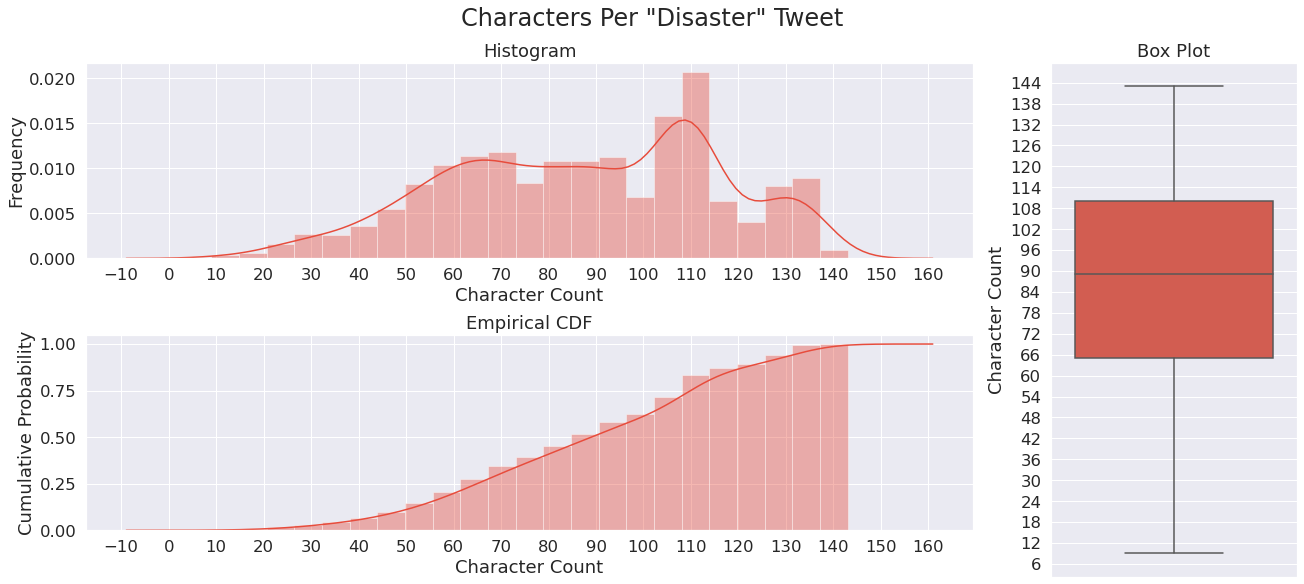

In [ ]:
plot_dist3(trainv[trainv['target'] == 1], 'Character Count',
           'Characters Per "Disaster" Tweet')

<a id="Word_Counts"></a>
## Word Counts

#### Ok let's check number of words per tweet now, they both look somewhat normally distributed, again disaster tweets seems to have slightly more words than non disaster ones. We might dig this deeper to get some more info in next part...



In [ ]:
def plot_word_number_histogram(textno, textye):

    """A function for comparing word counts"""

    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), sharey=True)
    sns.distplot(textno.str.split().map(lambda x: len(x)), ax=axes[0], color='#e74c3c')
    sns.distplot(textye.str.split().map(lambda x: len(x)), ax=axes[1], color='#e74c3c')

    axes[0].set_xlabel('Word Count')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Non Disaster Tweets')
    axes[1].set_xlabel('Word Count')
    axes[1].set_title('Disaster Tweets')

    fig.suptitle('Words Per Tweet', fontsize=24, va='baseline')

    fig.tight_layout()

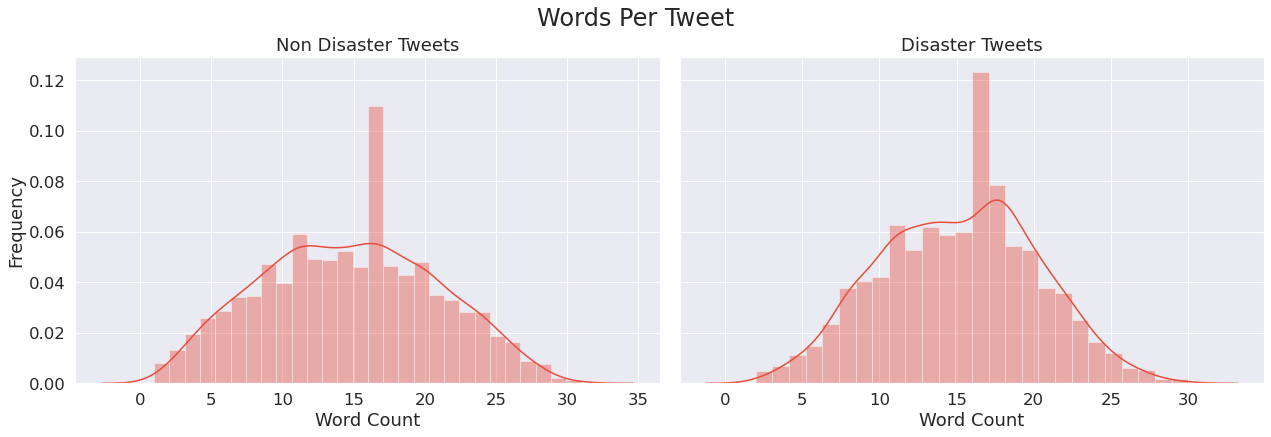

In [ ]:
plot_word_number_histogram(trainv[trainv['target'] == 0]['text'],
                           trainv[trainv['target'] == 1]['text'])

<a id="Word_Lengths"></a>
## Word Lengths

#### This time we're gonna check if word complexity differs from tweet class. It looks like disaster tweets has longer words than non disaster ones in general. It's pretty visible which is good sign, yet again we can only assume at this stage...



In [ ]:
def plot_word_len_histogram(textno, textye):

    """A function for comparing average word length"""

    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), sharey=True)
    sns.distplot(textno.str.split().apply(lambda x: [len(i) for i in x]).map(
        lambda x: np.mean(x)),
                 ax=axes[0], color='#e74c3c')
    sns.distplot(textye.str.split().apply(lambda x: [len(i) for i in x]).map(
        lambda x: np.mean(x)),
                 ax=axes[1], color='#e74c3c')

    axes[0].set_xlabel('Word Length')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Non Disaster Tweets')
    axes[1].set_xlabel('Word Length')
    axes[1].set_title('Disaster Tweets')

    fig.suptitle('Mean Word Lengths', fontsize=24, va='baseline')
    fig.tight_layout()


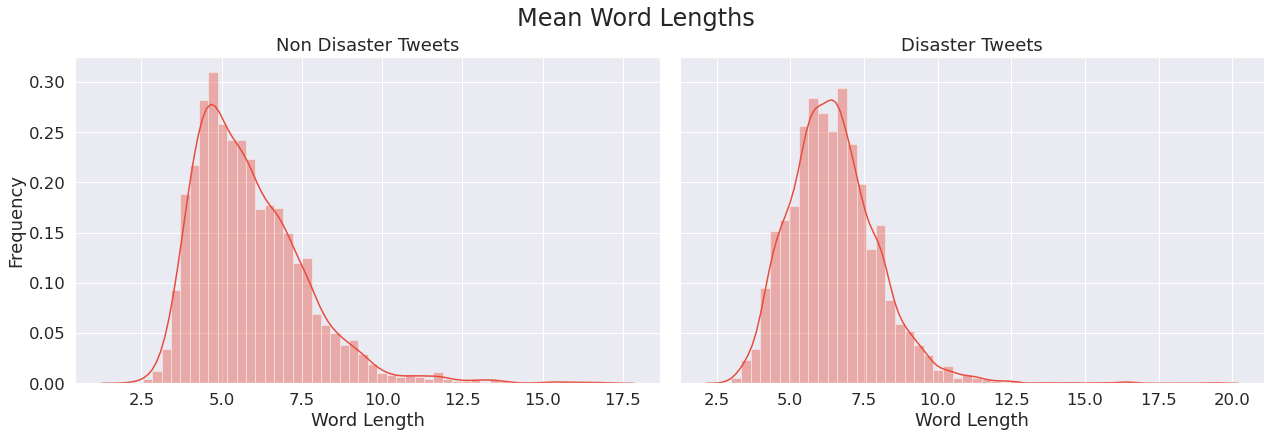

In [ ]:
plot_word_len_histogram(trainv[trainv['target'] == 0]['text'],
                        trainv[trainv['target'] == 1]['text'])

In [ ]:
lis = [
    trainv[trainv['target'] == 0]['lemma_str'],
    trainv[trainv['target'] == 1]['lemma_str']
]

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()

for i, j in zip(lis, axes):
    try:
        new = i.str.split()
        new = new.values.tolist()
        corpus = [word.lower() for i in new for word in i]
        dic = defaultdict(int)
        for word in corpus:
            if word in stop:
                dic[word] += 1

        top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:15]
        x, y = zip(*top)
        df = pd.DataFrame([x, y]).T
        df = df.rename(columns={0: 'Stopword', 1: 'Count'})
        sns.barplot(x='Count', y='Stopword', data=df, palette='plasma', ax=j)
        plt.tight_layout()
    except:
        plt.close()
        print('No stopwords left in texts.')
        break

No stopwords left in texts.


<a id="Most_Common_Words"></a>
## Most Common Words

#### It's time to move to words themselves instead of their quantitative features. We start with most common words in both classes. I'd say it's pretty obvious if it's from disaster tweets or not. Disaster tweets has words like fire, kill, bomb indicating disasters. Meanwhile non disaster ones looks like pretty generic.




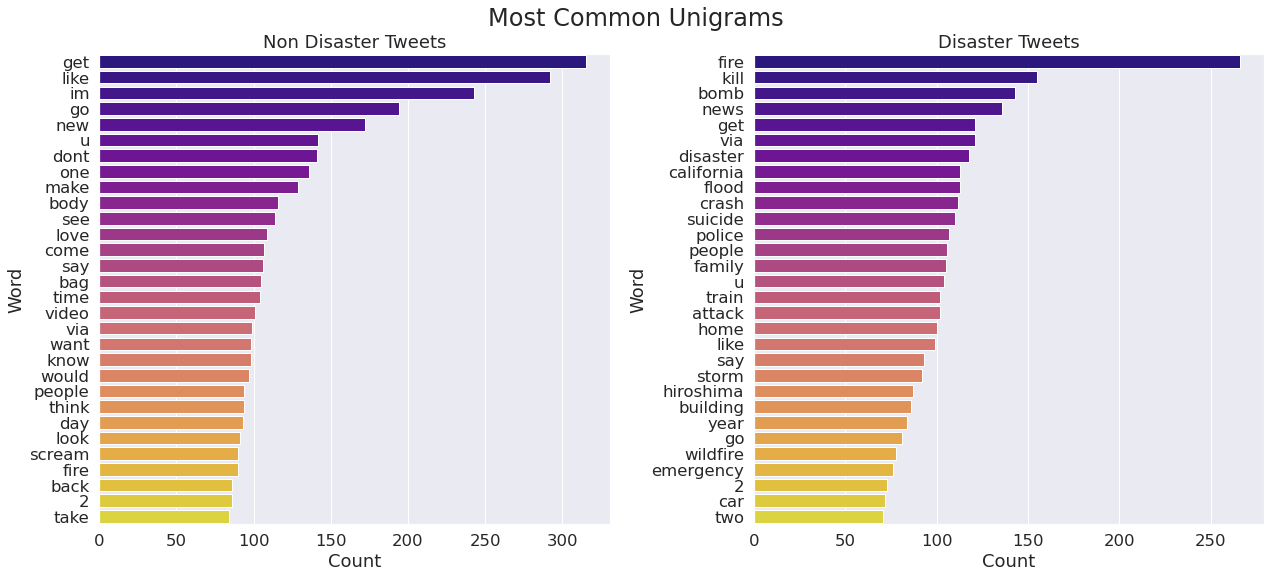

In [ ]:
# Displaying most common words.

fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()

for i, j in zip(lis, axes):

    new = i.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []
    for word, count in most[:30]:
        if (word not in stop):
            x.append(word)
            y.append(count)

    sns.barplot(x=y, y=x, palette='plasma', ax=j)
axes[0].set_title('Non Disaster Tweets')

axes[1].set_title('Disaster Tweets')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Word')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Word')

fig.suptitle('Most Common Unigrams', fontsize=24, va='baseline')
plt.tight_layout()

In [ ]:
def ngrams(n, title):
    """A Function to plot most common ngrams"""
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    axes = axes.flatten()
    for i, j in zip(lis, axes):

        new = i.str.split()
        new = new.values.tolist()
        corpus = [word for i in new for word in i]

        def _get_top_ngram(corpus, n=None):
            #getting top ngrams
            vec = CountVectorizer(ngram_range=(n, n),
                                  max_df=0.9,
                                  stop_words='english').fit(corpus)
            bag_of_words = vec.transform(corpus)
            sum_words = bag_of_words.sum(axis=0)
            words_freq = [(word, sum_words[0, idx])
                          for word, idx in vec.vocabulary_.items()]
            words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
            return words_freq[:15]

        top_n_bigrams = _get_top_ngram(i, n)[:15]
        x, y = map(list, zip(*top_n_bigrams))
        sns.barplot(x=y, y=x, palette='plasma', ax=j)

        axes[0].set_title('Non Disaster Tweets')
        axes[1].set_title('Disaster Tweets')
        axes[0].set_xlabel('Count')
        axes[0].set_ylabel('Words')
        axes[1].set_xlabel('Count')
        axes[1].set_ylabel('Words')
        fig.suptitle(title, fontsize=24, va='baseline')
        plt.tight_layout()

<a id="Most_Common_Bigrams"></a>
## Most Common Bigrams

#### Let's have a look for bigrams this time, which they are sequences of adjacent two words. Again it's pretty obvious to seperate two classes if it's disaster related or not. There are some confusing bigrams in non disaster ones like  body bag, emergency service etc. which needs deeper research but we'll leave it here since we got what we looking for in general.



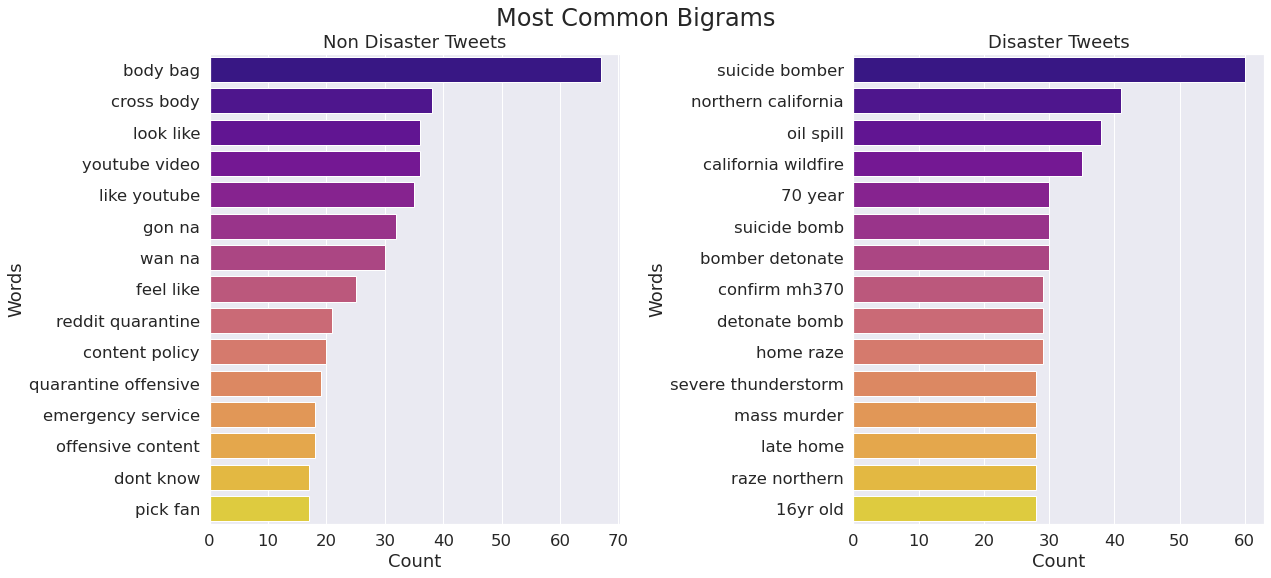

In [ ]:
ngrams(2, 'Most Common Bigrams')

<a id="Most_Common_Trigrams"></a>
## Most Common Trigrams

#### Alright! Things are much clearer with sequences of 3 words. The confusing body bags were cross body bags (Who uses them in these days anyways!) which I found it pretty funny when I found the reason of the confusion. Anyways we can see disasters are highly seperable now from non disaster ones, which is great!



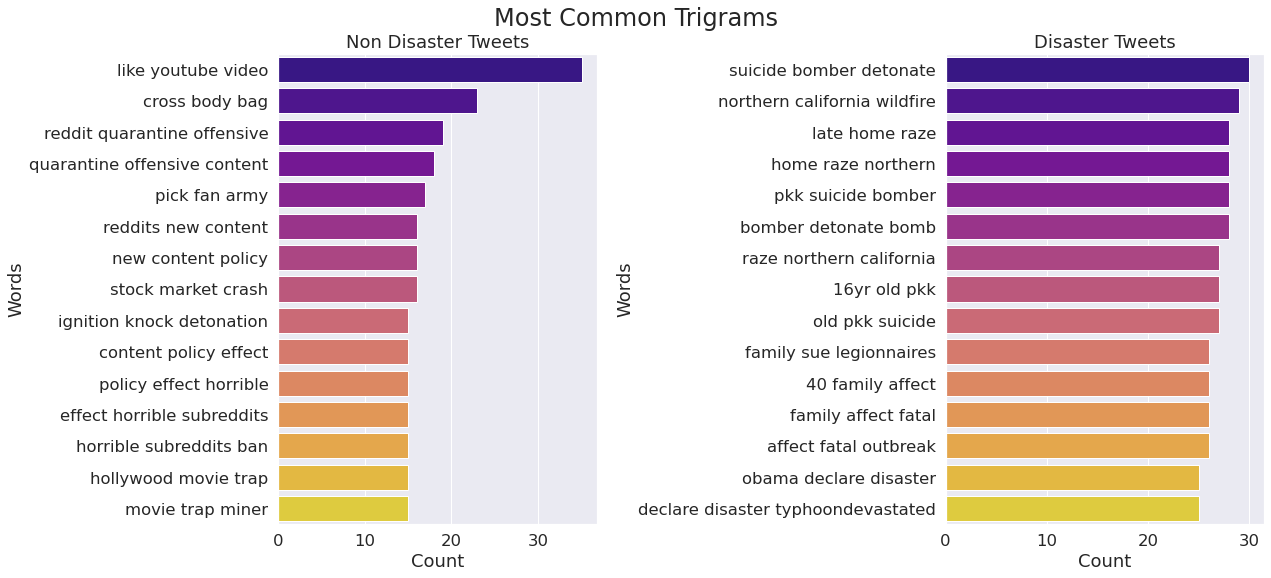

In [ ]:
ngrams(3, 'Most Common Trigrams')

<a id="Some_Extra_Analysis"></a>
# Some Extra Analysis

#### In this part we gonna apply some other analysis tecniques to gain some more insights about our dataset let's see what we can get from them...



<a id="Determining_Topics"></a>
## Determining Topics

#### We'll be using a method called Non-Negative Matrix Factorization (NMF) to see if we can get some defined topics out of our TF-IDF matrix, with this way TF-IDF will decrease impact of the high frequency words, so we might get more specific topics.

#### When we inspect our top ten topics we might need to use little imagination to help us understand them. Well actually they are pretty seperable again, I'd say disaster topics are much more clearer to read, we can see the topics directly by looking at them, meanwhile non disaster ones are more personal topics...



In [ ]:
def display_topics(text, no_top_words, topic):

    """ A function for determining the topics present in our corpus with nmf """

    no_top_words = no_top_words
    tfidf_vectorizer = TfidfVectorizer(
        max_df=0.90, min_df=25, max_features=5000, use_idf=True)
    tfidf = tfidf_vectorizer.fit_transform(text)
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()
    doc_term_matrix_tfidf = pd.DataFrame(
        tfidf.toarray(), columns=list(tfidf_feature_names))
    nmf = NMF(n_components=10, random_state=0,
              alpha=.1, init='nndsvd').fit(tfidf)
    print(topic)
    for topic_idx, topic in enumerate(nmf.components_):
        print('Topic %d:' % (topic_idx+1))
        print(' '.join([tfidf_feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))


display_topics(lis[0], 10, 'Non Disaster Topics\n')

Non Disaster Topics

Topic 1:
get lol blow good bomb first day demolish someone play
Topic 2:
like video youtube look feel back fire fatality sink mudslide
Topic 3:
im traumatise still disaster na gon attack drown dead weapon
Topic 4:
new emergency full read content post quarantine many storm re
Topic 5:
body bag cross shoulder woman full lady read ebay really
Topic 6:
dont one see know come say make want think fire
Topic 7:
scream fuck phone face good song loud hit baby time
Topic 8:
via youtube god change obliteration news story stop service video
Topic 9:
go content quarantine many explode make reddit let top deluge
Topic 10:
love crush collide woman much death military armageddon would check


In [ ]:
display_topics(lis[1], 10,'Disaster Topics\n')

Disaster Topics

Topic 1:
fire forest building truck evacuate wild burn california service set
Topic 2:
suicide bomb kill bomber saudi mosque detonate pkk old 16yr
Topic 3:
california wildfire home northern late news raze abc collapse burn
Topic 4:
flood storm rain people train issue severe weather rescue violent
Topic 5:
hiroshima atomic bomb year japan still anniversary 70 war bombing
Topic 6:
via attack wave israeli police evacuation heat post wound car
Topic 7:
mh370 family confirm malaysia wreckage pm debris conclusively investigator find
Topic 8:
disaster nuclear obama natural declare saipan typhoondevastated sign collapse northern
Topic 9:
crash kill accident helicopter air train fear say police car
Topic 10:
get watch minute sandstorm swallow airport go im like dont


<a id="Named_Entity_Recognition"></a>
## Named Entity Recognition

#### One last thing before we move on the modelling is Named Entity Recognition. It's a method for extracting information from text and returns which entities that are present in the text are classified into predefined entity types like "Person", "Place", "Organization", etc. By using NER we can get great insights about the types of entities present in the given text dataset.

#### When we look our NER results we can get lots of great insights. We can see that in disaster tweets countries, cities, states are much more common than non disaster ones. Again nationality or religious or political group names are more likely to be mentioned in disaster tweets. These are great indicators for us...



In [ ]:
# Loading NER.
nlp = en_core_web_sm.load()

In [ ]:
def plot_named_entity_barchart(text):

    """A function for extracting named entities and comparing them"""

    def _get_ner(text):
        doc = nlp(text)
        return [X.label_ for X in doc.ents]

    ent = text.apply(lambda x: _get_ner(x))
    ent = [x for sub in ent for x in sub]
    counter = Counter(ent)
    count = counter.most_common()

    x, y = map(list, zip(*count))
    sns.barplot(x=y, y=x)

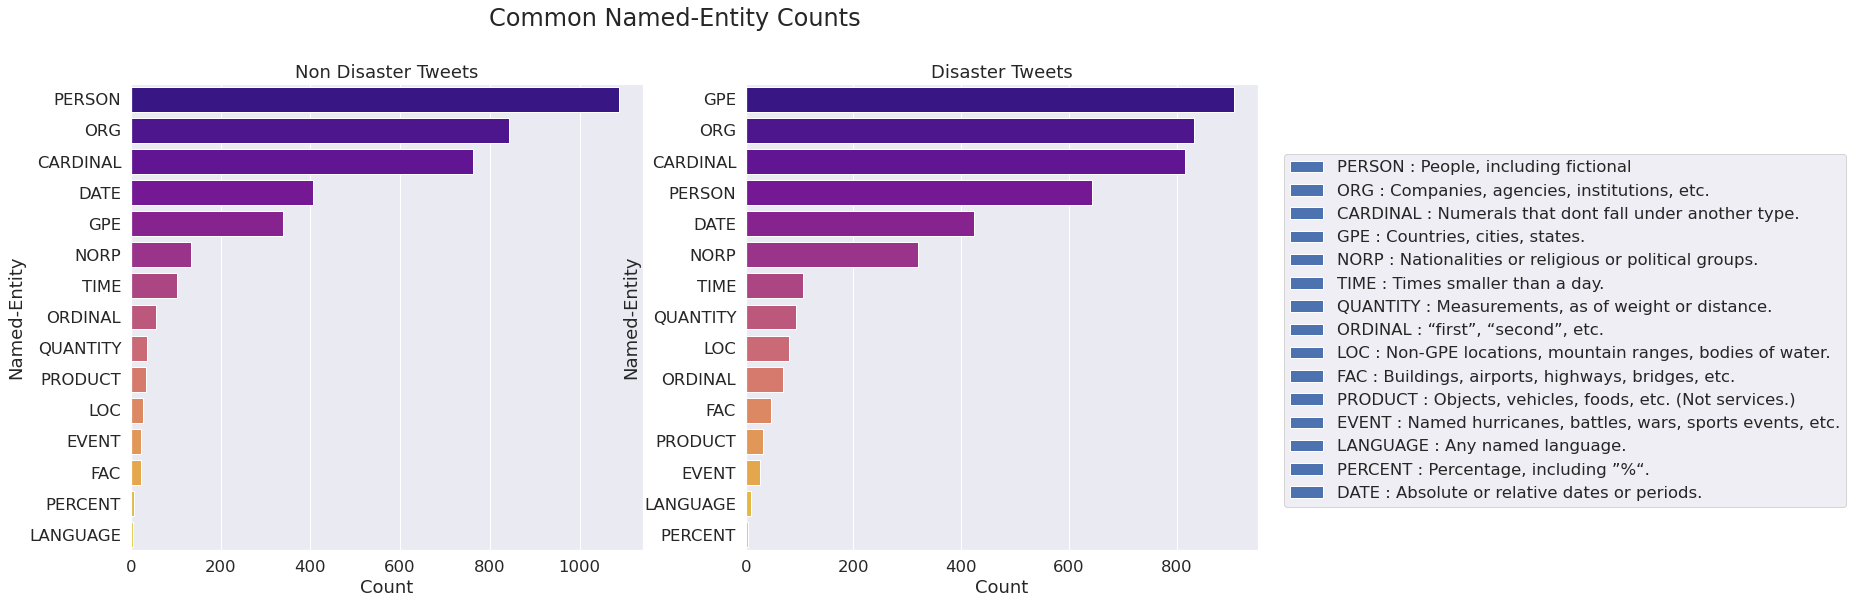

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()
for i, j in zip(lis, axes):

    def _get_ner(i):
        doc = nlp(i)
        return [X.label_ for X in doc.ents]

    ent = i.apply(lambda x: _get_ner(x))
    ent = [x for sub in ent for x in sub]
    counter = Counter(ent)
    count = counter.most_common()[:15]

    x, y = map(list, zip(*count))
    sns.barplot(x=y, y=x, ax=j, palette='plasma')

axes[0].set_title('Non Disaster Tweets')
axes[1].set_title('Disaster Tweets')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Named-Entity')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Named-Entity')
fig.suptitle('Common Named-Entity Counts', fontsize=24, va='baseline')



patch1 = mpatches.Patch(label='PERSON : People, including fictional')
patch2 = mpatches.Patch(label='ORG : Companies, agencies, institutions, etc.')
patch3 = mpatches.Patch(label='CARDINAL : Numerals that dont fall under another type.')
patch4 = mpatches.Patch(label='GPE : Countries, cities, states.')
patch5 = mpatches.Patch(label='NORP : Nationalities or religious or political groups.')
patch6 = mpatches.Patch(label='TIME : Times smaller than a day.')
patch7 = mpatches.Patch(label='QUANTITY : Measurements, as of weight or distance.')
patch8 = mpatches.Patch(label='ORDINAL : “first”, “second”, etc.')
patch9 = mpatches.Patch(label='LOC : Non-GPE locations, mountain ranges, bodies of water.')
patch10 = mpatches.Patch(label='FAC : Buildings, airports, highways, bridges, etc.')
patch11 = mpatches.Patch(label='PRODUCT : Objects, vehicles, foods, etc. (Not services.)')
patch12 = mpatches.Patch(label='EVENT : Named hurricanes, battles, wars, sports events, etc.')
patch13 = mpatches.Patch(label='LANGUAGE : Any named language.')
patch14 = mpatches.Patch(label='PERCENT : Percentage, including ”%“.')
patch15 = mpatches.Patch(label='DATE : Absolute or relative dates or periods.')



plt.legend(handles=[patch1, patch2, patch3, patch4, patch5, patch6, patch7, patch8, patch9, patch10, patch11, patch12, patch13, patch14, patch15, ],bbox_to_anchor=(1.05, 0.85), loc='upper left', borderaxespad=0.)

plt.show()

<a id="Building_the_Model"></a>
# Building the Bert Model



<a id="Getting_Things_Ready"></a>
## Getting Things Ready

#### Let's start with setting our main computing device.


In [ ]:
# If there's a GPU available...

if torch.cuda.is_available():

    device = torch.device('cuda')


    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device('cpu')

In [ ]:
# Loading the data for modelling.

train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

print(f'Number of training tweets: {train.shape[0]}\n')
print(f'Number of training tweets: {test.shape[0]}\n')

display(train.sample(10))

Number of training tweets: 7613

Number of training tweets: 3263



id            keyword         location  \
4094  5819               hail      Calgary, AB   
3506  5010          explosion    Kauai, Hawaii   
6141  8760              siren  Michel Delving.   
657    951              blaze   Rio de Janeiro   
4729  6725               lava              USA   
722   1043           bleeding    Baltimore, MD   
840   1219           blizzard   Ontario Canada   
5637  8038           refugees          Skyhold   
6457  9238  suicide%20bombing              NaN   
47      67             ablaze              NaN   

                                                   text  target  
4094                   @HeyItsEpark heavy rain and hail       1  
3506  The government is concerned about the populati...       0  
6141  Apparently they're going to have a WW2 siren t...       0  
657   I liked a @YouTube video from @iamrrsb http://...       0  
4729  Deal of The Day : http://t.co/US0qQqhQVj Brand...       0  
722   @DarrylB1979 yea heard about that..not coming ...       0  
840                    @TCGReno just hard reset my Xbox       0  
5637  @fadelurker @dalinthanelan &lt; right now.\n\n...       1  
6457  Remembering Mordechai Yehuda Friedman 24 of Ra...       1  
47    Building the perfect tracklist to life leave t...       0

In [ ]:
# Setting target variables, creating combined data and saving index for dividing combined data later.

labels = train['target'].values
idx = len(labels)
combined = pd.concat([train, test])
combined = combined.text.values

<a id="Tokenization_and_Formatting_the_Inputs"></a>
## Tokenization and Formatting the Inputs

#### For feeding our text to BERT we have to tokenize our text first and then these tokens must be mapped. For this job we gonna download and use BERT's own tokenizer. Thanks to Transformers library it's like one line of code, we also convert our tokens to lowercase for uncased model. You can see how the tokenizer works below there on first row of tweets for example.

#### We set our max len according to our tokenized sentences for padding and truncation, then we use tokenizer.encode_plus it'll split the sentences into tokens, then adds special tokens for classificication [CLS]:
> The first token of every sequence is always a special classification token ([CLS]). The final hidden state corresponding to this token is used as the aggregate sequence representation for classification tasks. (from the BERT paper)
#### Then it adds [SEP] tokens for making BERT decide if sentences are related. In our case it shouldn't be that important I think.

#### Then our tokenizer map's our tokens to their IDs first and pads or truncates all sentences to same length according to our max length. If sentence is longer than our limit it gets truncated, if it's shorter than our defined length then it adds [PAD] tokens to get them in same length.

#### Finally tokenizer create attention masks which is consisting of 1's and 0's for differentiating [PAD] tokens from the actual tokens.

#### We do these steps for each train and test set and then get our converted data for our BERT model. We also split train test on our train data for checking our models accuracy.




In [ ]:
# Tokenizing the combined text data using bert tokenizer.

tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)

In [ ]:
# Print the original tweet.

print(' Original: ', combined[0])

# Print the tweet split into tokens.

print('Tokenized: ', tokenizer.tokenize(combined[0]))

# Print the sentence mapped to token ID's.

print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(combined[0])))

 Original:  Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Tokenized:  ['our', 'deeds', 'are', 'the', 'reason', 'of', 'this', '#', 'earthquake', 'may', 'allah', 'forgive', 'us', 'all']
Token IDs:  [2256, 15616, 2024, 1996, 3114, 1997, 2023, 1001, 8372, 2089, 16455, 9641, 2149, 2035]


In [ ]:
max_len = 0

# For every sentence...

for text in combined:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.

    input_ids = tokenizer.encode(text, add_special_tokens=True)

    # Update the maximum sentence length.

    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  84


In [ ]:
# Making list of sentence lenghts:

token_lens = []

for text in combined:
    tokens = tokenizer.encode(text, max_length = 512)
    token_lens.append(len(tokens))

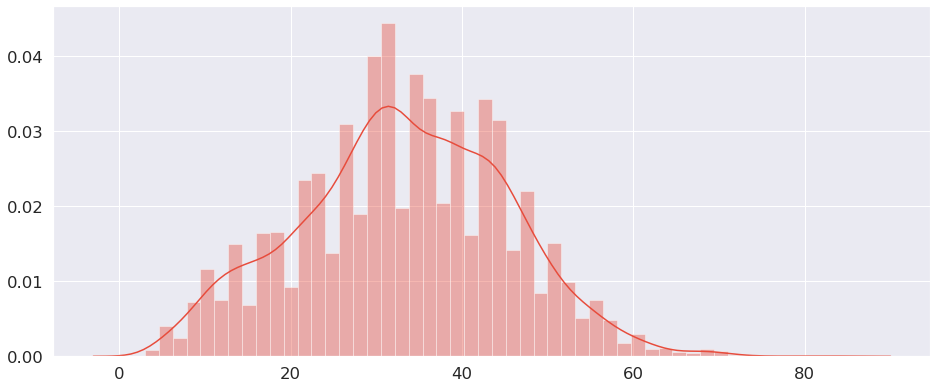

In [ ]:
# Displaying sentence length dist.

fig, axes = plt.subplots(figsize=(14, 6))
sns.distplot(token_lens, color='#e74c3c')
plt.show()

### I choose max len of 84 since it's the longest sentence we have here, playing with this number might get different results but the bigger you choose the slower the model will be!

In [ ]:
# Splitting the train test data after tokenizing.

train= combined[:idx]
test = combined[idx:]
train.shape

(7613,)

In [ ]:
def tokenize_map(sentence,labs='None'):

    """A function for tokenize all of the sentences and map the tokens to their word IDs."""

    global labels

    input_ids = []
    attention_masks = []

    # For every sentence...

    for text in sentence:
        #   "encode_plus" will:

        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.

        encoded_dict = tokenizer.encode_plus(
                            text,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            truncation='longest_first', # Activate and control truncation
                            max_length = 84,           # Max length according to our text data.
                            pad_to_max_length = True, # Pad & truncate all sentences.
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )

        # Add the encoded sentence to the id list.

        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).

        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    if labs != 'None': # Setting this for using this definition for both train and test data so labels won't be a problem in our outputs.
        labels = torch.tensor(labels)
        return input_ids, attention_masks, labels
    else:
        return input_ids, attention_masks

In [ ]:
# Tokenizing all of the train test sentences and mapping the tokens to their word IDs.

input_ids, attention_masks, labels = tokenize_map(train, labels)
test_input_ids, test_attention_masks= tokenize_map(test)

In [ ]:
# Combine the training inputs into a TensorDataset.

dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 80-20 train-validation split.

# Calculate the number of samples to include in each set.

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

6,090 training samples
1,523 validation samples


In [ ]:
# The DataLoader needs to know our batch size for training, so we specify it here. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.

batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.

train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.

validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
prediction_data = TensorDataset(test_input_ids, test_attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

<a id="Setting_the_Bert_Classification_Model"></a>
## Setting the Bert Classification Model

#### It's time to load our model, exciting right?! Thanks to Transformers library we have exact tools we need for classification task. We set bert-large-uncased for the more accurate results and assign 2 labels for classification.

#### You can see the model parameters down there, it's pretty straightforward with the transformers.

#### Then we choose our optimizer and fine-tune our model. Again these hyperparameters (learning_rate, epsilon, epochs etc.) are recommended on the official BERT paper.



In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top.

model = BertForSequenceClassification.from_pretrained(
    'bert-large-uncased', # Use the 124-layer, 1024-hidden, 16-heads, 340M parameters BERT model with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification. You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the device which we set GPU in our case.

model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1

In [ ]:
# Get all of the model's parameters as a list of tuples:

params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))

The BERT model has 393 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 1024)
bert.embeddings.position_embeddings.weight               (512, 1024)
bert.embeddings.token_type_embeddings.weight               (2, 1024)
bert.embeddings.LayerNorm.weight                             (1024,)
bert.embeddings.LayerNorm.bias                               (1024,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight        (1024, 1024)
bert.encoder.layer.0.attention.self.query.bias               (1024,)
bert.encoder.layer.0.attention.self.key.weight          (1024, 1024)
bert.encoder.layer.0.attention.self.key.bias                 (1024,)
bert.encoder.layer.0.attention.self.value.weight        (1024, 1024)
bert.encoder.layer.0.attention.self.value.bias               (1024,)
bert.encoder.layer.0.attention.output.dense.weight      (1024, 1024)
bert.encoder.layer.0.attention.output.dense.bias             (

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch).

# The 'W' stands for 'Weight Decay fix' probably

optimizer = AdamW(model.parameters(),
                  lr = 6e-6, # args.learning_rate
                  eps = 1e-8 # args.adam_epsilon
                )

In [ ]:
# Number of training epochs. The BERT authors recommend between 2 and 4.

# We chose to run for 3, but we'll see later that this may be over-fitting the training data.

epochs = 3

# Total number of training steps is [number of batches] x [number of epochs] (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

<a id="Training_and_Evaluating"></a>
## Training and Evaluating

#### Time to train our model! First we set some helper functions to calculate our metrics and time spent on the process. Then it moves like this, directly from the original notebook, it's pretty good at explaining I shouldn't confuse you with my own way of telling I guess:


> Training:

>-    Unpack our data inputs and labels
-    Load data onto the GPU for acceleration,
-    Clear out the gradients calculated in the previous pass,
     -   In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out,
-    Forward pass (feed input data through the network),
-    Backward pass (backpropagation),
-    Tell the network to update parameters with optimizer.step(),
-    Track variables for monitoring progress.

>Evalution:

>-    Unpack our data inputs and labels,
-    Load data onto the GPU for acceleration,
-    Forward pass (feed input data through the network),
-    Compute loss on our validation data and track variables for monitoring progress.

Pytorch hides all of the detailed calculations from us, but we've commented the code to point out which of the above steps are happening on each line.


The code below trains according to our data and saves the learning progress on the way so we can summarize at the end and see our results. We can also turn these to dataframe and plot it to see our eavluation better. So we can decide if the model performs well and not overfitting...



In [ ]:
def flat_accuracy(preds, labels):

    """A function for calculating accuracy scores"""

    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return accuracy_score(labels_flat, pred_flat)

def flat_f1(preds, labels):

    """A function for calculating f1 scores"""

    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return f1_score(labels_flat, pred_flat)

In [ ]:
def format_time(elapsed):

    """A function that takes a time in seconds and returns a string hh:mm:ss"""

    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
# We'll store a number of quantities such as training and validation loss, validation accuracy, f1 score and timings.

training_stats = []

# Measure the total training time for the whole run.

total_t0 = time.time()

for epoch_i in range(0, epochs):

    # Perform one full pass over the training set.

    print('')
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes:

    t0 = time.time()

    # Reset the total loss for this epoch.

    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to `train` just changes the *mode*, it doesn't *perform* the training.`dropout` and `batchnorm` layers behave differently during training vs. test ,

    model.train()


    for step, batch in enumerate(train_dataloader):

        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.

        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels

        b_input_ids = batch[0].to(device).to(torch.int64)
        b_input_mask = batch[1].to(device).to(torch.int64)
        b_labels = batch[2].to(device).to(torch.int64)



        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).

        # It returns different numbers of parameters depending on what arguments given and what flags are set. For our useage here, it returns the loss (because we provided labels),
        # And the 'logits' (the model outputs prior to activation.)

        loss, logits = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end,
        # `loss` is a tensor containing a single value; the `.item()` function just returns the Python value from the tensor.

        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients, as pytorch dont have automatic backward loss

        loss.backward()

        # Clip the norm of the gradients to 1.0 This is to help prevent the 'exploding gradients' problem.

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.

        # The optimizer dictates the 'update rule'(How the parameters are modified based on their gradients, the learning rate, etc.)

        optimizer.step()

        # Update the learning rate.

        scheduler.step()

    # Calculate the average loss over all of the batches.

    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.

    training_time = format_time(time.time() - t0)

    print('')
    print('  Average training loss: {0:.2f}'.format(avg_train_loss))
    print('  Training epcoh took: {:}'.format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on our validation set.

    print('')
    print('Running Validation...')

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently during evaluation.

    model.eval()

    # Tracking variables:

    total_eval_accuracy = 0
    total_eval_loss = 0
    total_eval_f1 = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch.

    for batch in validation_dataloader:

        # Unpack this training batch from our dataloader.

        # As we unpack the batch, we'll also copy each tensor to the GPU using the `to` method.

        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during the forward pass, since this is only needed for backprop (training part).

        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the 'segment ids', which differentiates sentence 1 and 2 in 2-sentence tasks.

            #used idea of https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers BertForSequenceClassification.
            # Get the 'logits' output by the model. The 'logits' are the output values prior to applying an activation function like the softmax.

            (loss, logits) = model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)

        # Accumulate the validation loss.

        total_eval_loss += loss.item()

        # Move logits and labels to CPU:

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and accumulate it over all batches:

        total_eval_accuracy += flat_accuracy(logits, label_ids)
        total_eval_f1 += flat_f1(logits, label_ids)


    # Report the final accuracy for this validation run.

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print('  Accuracy: {0:.2f}'.format(avg_val_accuracy))

    # Report the final f1 score for this validation run.

    avg_val_f1 = total_eval_f1 / len(validation_dataloader)
    print('  F1: {0:.2f}'.format(avg_val_f1))

    # Calculate the average loss over all of the batches.

    avg_val_loss = total_eval_loss / len(validation_dataloader)



    # Measure how long the validation run took:

    validation_time = format_time(time.time() - t0)

    print('  Validation Loss: {0:.2f}'.format(avg_val_loss))
    print('  Validation took: {:}'.format(validation_time))

    # Record all statistics from this epoch.

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Val_F1' : avg_val_f1,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print('')
print('Training complete!')

print('Total training took {:} (h:mm:ss)'.format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch    50  of    191.    Elapsed: 0:00:44.
  Batch   100  of    191.    Elapsed: 0:01:26.
  Batch   150  of    191.    Elapsed: 0:02:09.

  Average training loss: 0.50
  Training epcoh took: 0:02:43

Running Validation...
  Accuracy: 0.81
  F1: 0.77
  Validation Loss: 0.45
  Validation took: 0:00:13

======== Epoch 2 / 3 ========
Training...
  Batch    50  of    191.    Elapsed: 0:00:43.
  Batch   100  of    191.    Elapsed: 0:01:25.
  Batch   150  of    191.    Elapsed: 0:02:08.

  Average training loss: 0.38
  Training epcoh took: 0:02:42

Running Validation...
  Accuracy: 0.83
  F1: 0.78
  Validation Loss: 0.42
  Validation took: 0:00:13

======== Epoch 3 / 3 ========
Training...
  Batch    50  of    191.    Elapsed: 0:00:43.
  Batch   100  of    191.    Elapsed: 0:01:25.
  Batch   150  of    191.    Elapsed: 0:02:08.

  Average training loss: 0.33
  Training epcoh took: 0:02:42

Running Validation...
  Accuracy: 0.83
  F1: 0.78
  Valid

In [ ]:
# Display floats with two decimal places.

pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.

df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.

df_stats = df_stats.set_index('epoch')

# Display the table.

display(df_stats)

Training Loss  Valid. Loss  Valid. Accur.  Val_F1 Training Time  \
epoch                                                                    
1               0.50         0.45           0.81    0.77       0:02:43   
2               0.38         0.42           0.83    0.78       0:02:42   
3               0.33         0.43           0.83    0.78       0:02:42   

      Validation Time  
epoch                  
1             0:00:13  
2             0:00:13  
3             0:00:13

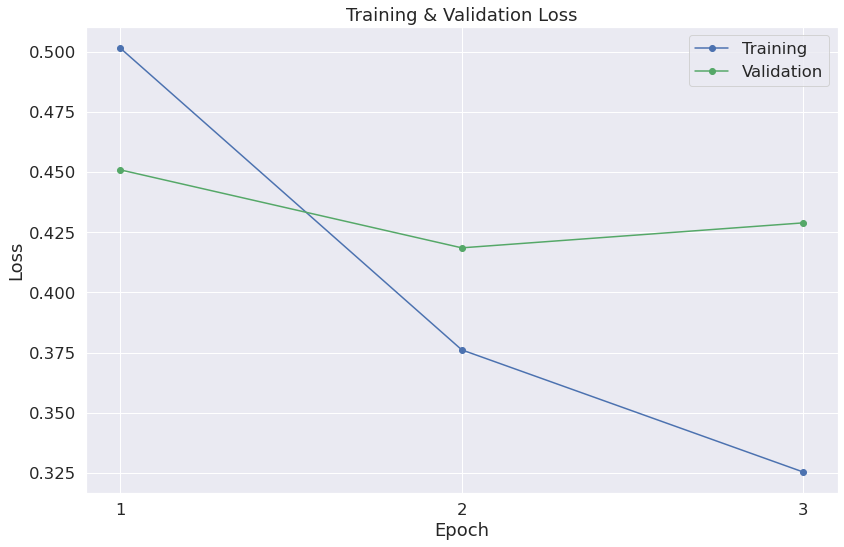

In [ ]:
# Increase the plot size and font size:

fig, axes = plt.subplots(figsize=(12,8))

# Plot the learning curve:

plt.plot(df_stats['Training Loss'], 'b-o', label='Training')
plt.plot(df_stats['Valid. Loss'], 'g-o', label='Validation')

# Label the plot:

plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.xticks([1, 2, 3])

plt.show()

<a id="Predicting_and_Submission"></a>
## Predicting and Submission

#### Ok we trained our model and it's ready to make predictions on our test data. Then we save them to csv file for submission, this part is pretty straightforward for the most of classification tasks.

### [Back To Table of Contents](#top_section)

In [ ]:
# Prediction on test set:

print('Predicting labels for {:,} test sentences...'.format(len(test_input_ids)))

# Put model in evaluation mode:

model.eval()

# Tracking variables :

predictions = []

# Predict:

for batch in prediction_dataloader:

  # Add batch to GPU

  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader:

  b_input_ids, b_input_mask, = batch

  # Telling the model not to compute or store gradients, saving memory and speeding up prediction:

  with torch.no_grad():
      # Forward pass, calculate logit predictions:

      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU:

  logits = logits.detach().cpu().numpy()


  # Store predictions and true labels:

  predictions.append(logits)


print('    DONE.')

Predicting labels for 3,263 test sentences...
    DONE.


In [ ]:
# Getting list of predictions and then choosing the target value with using argmax on probabilities.

flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

In [ ]:
# Creating submission data.

submission = pd.read_csv('content/sample_submission.csv')
submission['target'] = flat_predictions
submission.head(10)

id  target
0   0       1
1   2       1
2   3       1
3   9       1
4  11       1
5  12       1
6  21       0
7  22       0
8  27       0
9  29       0

In [ ]:
# Saving submission to '.csv' file:

submission.to_csv('submission.csv', index=False, header=True)

   

## Summary

**In this notebook I tried to apply what I learned on NLP.\
This notebook includes: Preprocessing the text, visualizing the processed data by several methods like tweet lenghts, word counts, average word lengths, ngrams etc.clean data before visualize it, should investigate the raw data you got first then move to cleaning in normal cases but \
At the last part we're going to implement BERT model to do tokenization, classification and prediction with using transformers.**




## References:

- [BERT Research from  Chris McCormick](https://www.youtube.com/watch?v=FKlPCK1uFrc): It was a great tutorial and helped me a lot through modelling part.
- [The Official BERT Paper](https://arxiv.org/pdf/1810.04805.pdf): It's helpful for understanding theory behind it also I used it while finetuning the model
- [Transformers Official Page](https://huggingface.co/transformers/quickstart.html): There are some good examples to write your own models.
- [Word Cloud GitHub Page](https://github.com/amueller/word_cloud): Again good examples for your word clouds.
- [Exploratory Data Analysis for NLP from Shahul Es](https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools): Learned a lot about NLP EDA's here.
- [NLP | Exploratory Data Analysis of Text Data from Kamil Mysiak](https://towardsdatascience.com/nlp-part-3-exploratory-data-analysis-of-text-data-1caa8ab3f79d): Again this EDA work was great example for me.